In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Electric_Consumption_And_Cost__2010_-_Feb_2025__20250507.csv')

In [3]:
df_temp = pd.read_csv('Electric_Consumption_And_Cost__2010_-_Feb_2025__20250507.csv', nrows=5)
print(df_temp.columns[17])

Meter Number


In [4]:
col_name = df_temp.columns[17]
df = pd.read_csv('Electric_Consumption_And_Cost__2010_-_Feb_2025__20250507.csv', usecols=[col_name])
print(df[col_name].unique()[:20])  # show first 20 unique values

['7223256' '7518362' '7515778' '7518352' '7725456' '7725454' '7725479'
 '19046' '4580863' '4989251' '4989493' '5081734' '5081895' '7662330'
 '5081862' '5081863' '6026253' '7031117' '5652244' '5652307']


In [5]:
df = pd.read_csv(
    'Electric_Consumption_And_Cost__2010_-_Feb_2025__20250507.csv',
    dtype={'Meter Number': str}
)

In [6]:
df.head()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 521035 entries, 0 to 521034
Data columns (total 27 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Development Name    520414 non-null  object 
 1   Borough             521035 non-null  object 
 2   Account Name        521035 non-null  object 
 3   Location            507102 non-null  object 
 4   Meter AMR           520266 non-null  object 
 5   Meter Scope         27636 non-null   object 
 6   TDS #               519157 non-null  float64
 7   EDP                 521035 non-null  int64  
 8   RC Code             521035 non-null  object 
 9   Funding Source      521035 non-null  object 
 10  AMP #               518672 non-null  object 
 11  Vendor Name         521035 non-null  object 
 12  UMIS BILL ID        521035 non-null  int64  
 13  Revenue Month       521035 non-null  object 
 14  Service Start Date  521027 non-null  object 
 15  Service End Date    521027 non-nul

TDS #            EDP  UMIS BILL ID         # days  \
count  519157.000000  521035.000000  5.210350e+05  521027.000000   
mean      116.499202     424.929924  7.480257e+06      30.361547   
std       128.773830     186.993741  4.033719e+06       2.596024   
min         0.000000      63.000000  1.726303e+06    -335.000000   
25%        33.000000     225.000000  3.788160e+06      29.000000   
50%        63.000000     426.000000  6.542550e+06      30.000000   
75%       145.000000     552.000000  1.095094e+07      31.000000   
max       582.000000     999.000000  1.488953e+07     749.000000   

       Current Charges  Consumption (KWH)    KWH Charges  Consumption (KW)  \
count    521035.000000       5.210350e+05  521035.000000     521035.000000   
mean       4284.955086       3.046078e+04    1433.879714         61.430595   
std        6210.140634       4.850114e+04    2463.710587        530.949951   
min      -25622.210000       0.000000e+00       0.000000          0.000000   
25%         649.990000       0.000000e+00       0.000000          0.000000   
50%        2260.500000       1.192600e+04     527.790000         21.020000   
75%        5601.970000       4.520000e+04    2051.190000         88.000000   
max      424298.640000       2.788773e+06  195575.860000     329074.000000   

          KW Charges  Other charges  
count  521035.000000  521035.000000  
mean      858.910986    1992.164385  
std      1494.695516    3835.804306  
min         0.000000  -59396.430000  
25%         0.000000       0.000000  
50%       249.400000     951.200000  
75%      1259.500000    2838.560000  
max     78782.960000  312524.970000

In [7]:
# Check for rows with missing or invalid dates
df['Service Start Date'] = pd.to_datetime(df['Service Start Date'], format='%m/%d/%Y', errors='coerce')
df['Service End Date'] = pd.to_datetime(df['Service End Date'], format='%m/%d/%Y', errors='coerce')

# Check for rows where either of the date columns is missing
invalid_dates = df[df['Service Start Date'].isna() | df['Service End Date'].isna()]


# Check the actual date values that caused issues
print(invalid_dates[['Service Start Date', 'Service End Date']])

# Drop rows with missing 'Service Start Date' or 'Service End Date'
initial_shape = df.shape
df = df.dropna(subset=['Service Start Date', 'Service End Date'])

# Verify that the rows were removed and print a message
final_shape = df.shape
print(f"Rows removed: {initial_shape[0] - final_shape[0]}")
print(f"New shape of the DataFrame: {final_shape}")

       Service Start Date Service End Date
294047                NaT              NaT
296910                NaT              NaT
296913                NaT              NaT
334095                NaT              NaT
334096                NaT              NaT
334097                NaT              NaT
342672                NaT              NaT
342676                NaT              NaT
Rows removed: 8
New shape of the DataFrame: (521027, 27)


# Data Preprocessing

In [8]:
# Convert 'Revenue Month' to datetime format (monthly frequency)
df['Revenue Month'] = pd.to_datetime(df['Revenue Month'], format='%Y-%m', errors='coerce')

# Check the format
print(df[['Revenue Month','Service Start Date','Service End Date']].head())


  Revenue Month Service Start Date Service End Date
0    2010-01-01         2009-12-24       2010-01-26
1    2010-02-01         2010-01-26       2010-02-25
2    2010-03-01         2010-02-25       2010-03-26
3    2010-04-01         2010-03-26       2010-04-26
4    2010-05-01         2010-04-26       2010-05-24


In [9]:
print(df['Revenue Month'].dt.year.unique())  # List all months in the dataset


[2010 2012 2013 2014 2020 2015 2016 2019 2017 2021 2022 2023 2024]


In [10]:
# Check the original 'Revenue Month' values before converting
print(df['Revenue Month'].head())


0   2010-01-01
1   2010-02-01
2   2010-03-01
3   2010-04-01
4   2010-05-01
Name: Revenue Month, dtype: datetime64[ns]


In [11]:
# Drop rows with missing 'Consumption (KWH)' values
df = df.dropna(subset=['Consumption (KWH)'])

# Drop rows where 'Consumption (KWH)' is zero or negative
df = df[df['Consumption (KWH)'] > 0]

# Drop duplicate rows
df = df.drop_duplicates()

# Keep only rows with valid dates within the desired range
df = df[(df['Service Start Date'] >= '2009-12-24') & (df['Service Start Date'] <= '2024-12-20')]


# Calculating Monthly, Yearly DataFrames

In [12]:
# Grouping by month and computing the mean consumption across all boroughs
monthly_df = (
    df
    .groupby('Revenue Month')['Consumption (KWH)']
    .mean()
    .reset_index()
)

# Rename to Prophet’s expected columns
monthly_df.rename(columns={
    'Revenue Month': 'ds', 
    'Consumption (KWH)': 'y'
}, inplace=True)

# check the monthly df
print(monthly_df.head())
monthly_df.info()


          ds             y
0 2010-01-01  47936.735039
1 2010-02-01  42432.595444
2 2010-03-01  40217.263636
3 2010-04-01  40470.970014
4 2010-05-01  40689.027236
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      156 non-null    datetime64[ns]
 1   y       156 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.6 KB


In [13]:
# REMOVE COMMENT IF WANT TO INTERPOLATE MISSING MONTHS/YEARS
"""# Create full monthly date range
full_range = pd.date_range(start=monthly_df['ds'].min(), 
                           end=monthly_df['ds'].max(), freq='MS')

# Reindex DataFrame to include missing months
monthly_df = monthly_df.set_index('ds').reindex(full_range).rename_axis('ds').reset_index()

# Interpolate missing 'y' values
monthly_df['y'] = monthly_df['y'].interpolate(method='linear')

# Check for any remaining nulls
print(monthly_df.isna().sum())"""


"# Create full monthly date range\nfull_range = pd.date_range(start=monthly_df['ds'].min(), \n                           end=monthly_df['ds'].max(), freq='MS')\n\n# Reindex DataFrame to include missing months\nmonthly_df = monthly_df.set_index('ds').reindex(full_range).rename_axis('ds').reset_index()\n\n# Interpolate missing 'y' values\nmonthly_df['y'] = monthly_df['y'].interpolate(method='linear')\n\n# Check for any remaining nulls\nprint(monthly_df.isna().sum())"

In [14]:
monthly_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      156 non-null    datetime64[ns]
 1   y       156 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.6 KB


In [15]:
# Grouping by year and computing the mean consumption
yearly_df = (
    df
    .groupby(df['Revenue Month'].dt.year)['Consumption (KWH)']
    .mean()
    .reset_index()
)

# Rename columns to match Prophet's expected format
yearly_df.rename(columns={
    'Revenue Month': 'ds', 
    'Consumption (KWH)': 'y'
}, inplace=True)

# Verify the result
print(yearly_df.head())
print(yearly_df['ds'].dtype)


     ds             y
0  2010  49455.649352
1  2012  48659.248650
2  2013  47867.810567
3  2014  47124.951326
4  2015  48091.192263
int32


In [16]:
# Convert 'ds' column to datetime format (representing the first day of each year)
yearly_df['ds'] = pd.to_datetime(yearly_df['ds'], format='%Y')

# Verify the result
print(yearly_df.head())
print(yearly_df['ds'].dtype)


          ds             y
0 2010-01-01  49455.649352
1 2012-01-01  48659.248650
2 2013-01-01  47867.810567
3 2014-01-01  47124.951326
4 2015-01-01  48091.192263
datetime64[ns]


In [17]:
# REMOVE COMMENT IF WANT TO INTERPOLATE MISSING MONTHS/YEARS
"""# Step 1: Create a full range of years (as datetime, first of each year)
full_years = pd.date_range(start=yearly_df['ds'].min(), 
                           end=yearly_df['ds'].max(), freq='YS')

# Step 2: Reindex the DataFrame to include all years, even those missing from the original data
yearly_df = yearly_df.set_index('ds').reindex(full_years).rename_axis('ds').reset_index()

# Step 3: Interpolate missing 'y' values
yearly_df['y'] = yearly_df['y'].interpolate(method='linear')

# Optional: Check if there are any missing values
print(yearly_df.isna().sum())

# Optional: Display the range of original and reindexed years
print("Original years:", yearly_df['ds'].min(), "to", yearly_df['ds'].max())
print("Reindexed years:", full_years.min(), "to", full_years.max())

# Optional: View the updated DataFrame
yearly_df.info()"""


'# Step 1: Create a full range of years (as datetime, first of each year)\nfull_years = pd.date_range(start=yearly_df[\'ds\'].min(), \n                           end=yearly_df[\'ds\'].max(), freq=\'YS\')\n\n# Step 2: Reindex the DataFrame to include all years, even those missing from the original data\nyearly_df = yearly_df.set_index(\'ds\').reindex(full_years).rename_axis(\'ds\').reset_index()\n\n# Step 3: Interpolate missing \'y\' values\nyearly_df[\'y\'] = yearly_df[\'y\'].interpolate(method=\'linear\')\n\n# Optional: Check if there are any missing values\nprint(yearly_df.isna().sum())\n\n# Optional: Display the range of original and reindexed years\nprint("Original years:", yearly_df[\'ds\'].min(), "to", yearly_df[\'ds\'].max())\nprint("Reindexed years:", full_years.min(), "to", full_years.max())\n\n# Optional: View the updated DataFrame\nyearly_df.info()'

In [18]:
print(yearly_df['ds'].dt.year.unique())

[2010 2012 2013 2014 2015 2016 2017 2019 2020 2021 2022 2023 2024]


In [19]:
print(monthly_df.head())
print(monthly_df['ds'].dtype)

          ds             y
0 2010-01-01  47936.735039
1 2010-02-01  42432.595444
2 2010-03-01  40217.263636
3 2010-04-01  40470.970014
4 2010-05-01  40689.027236
datetime64[ns]


# Cleaning the Daily, Monthly, Yearly DataFrames

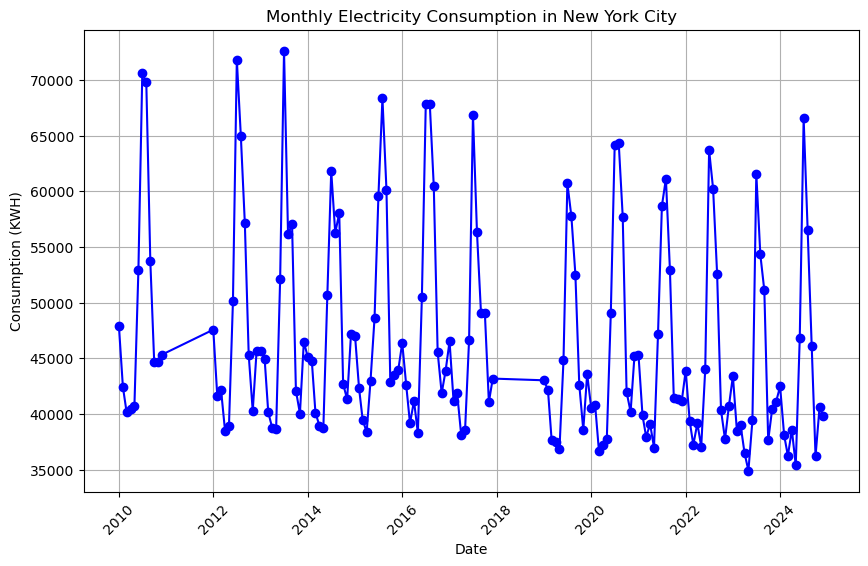

<Figure size 640x480 with 0 Axes>

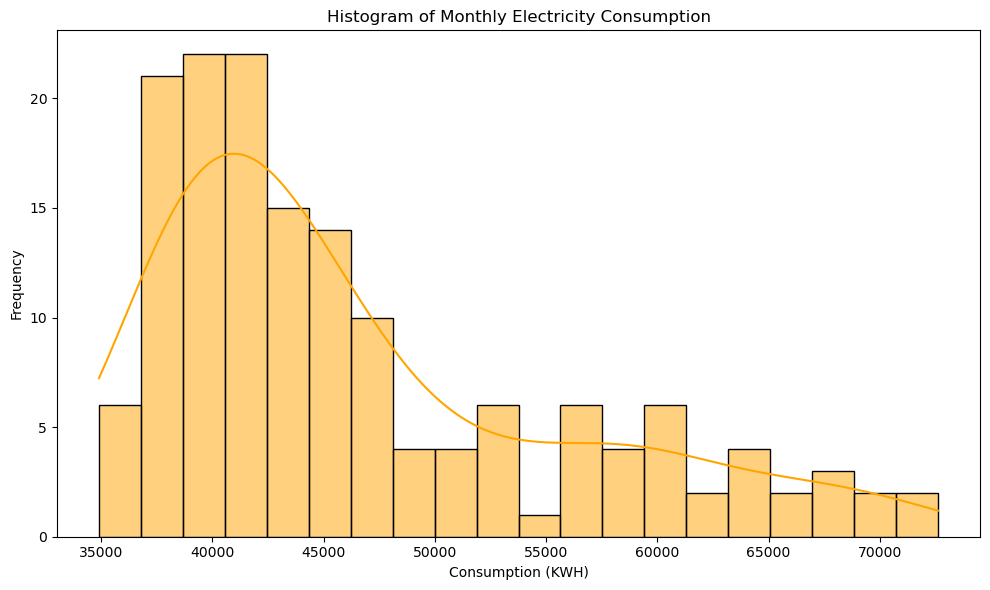

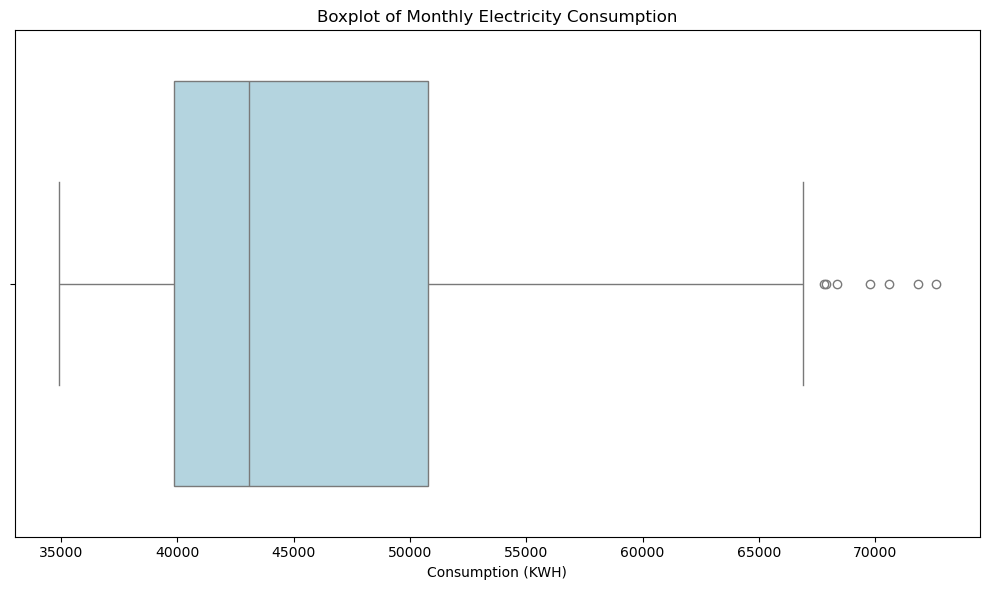

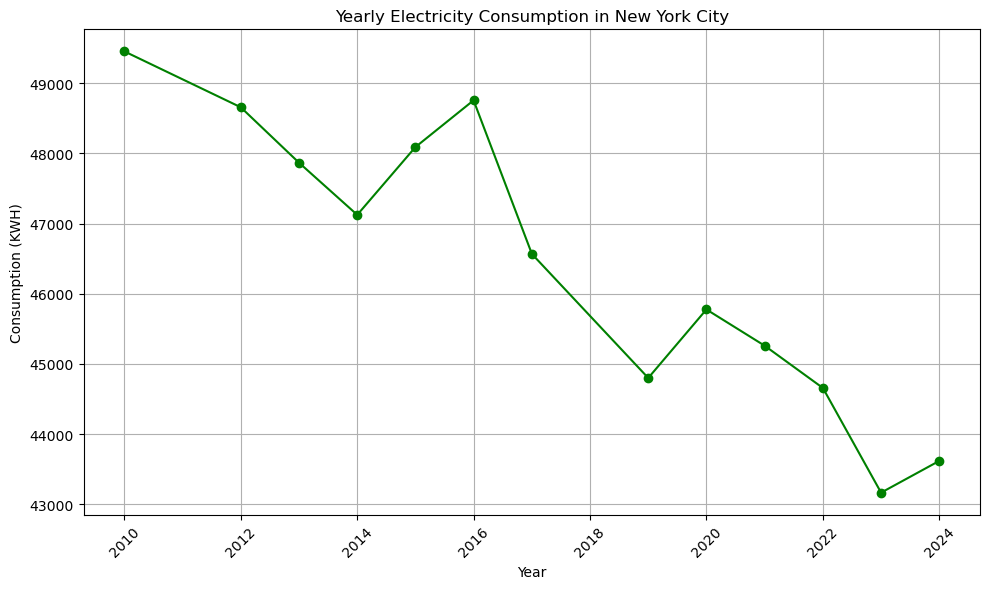

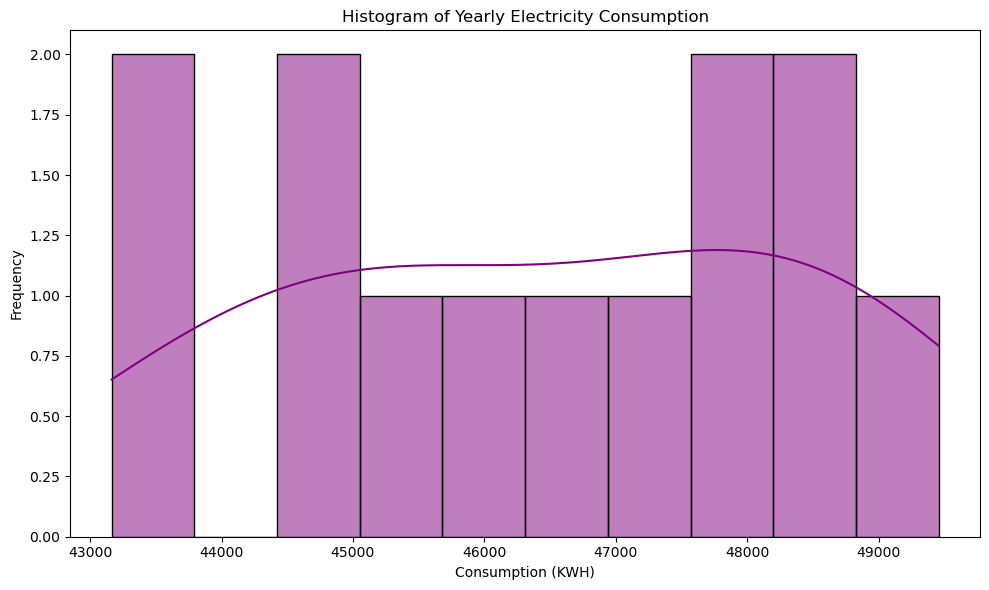

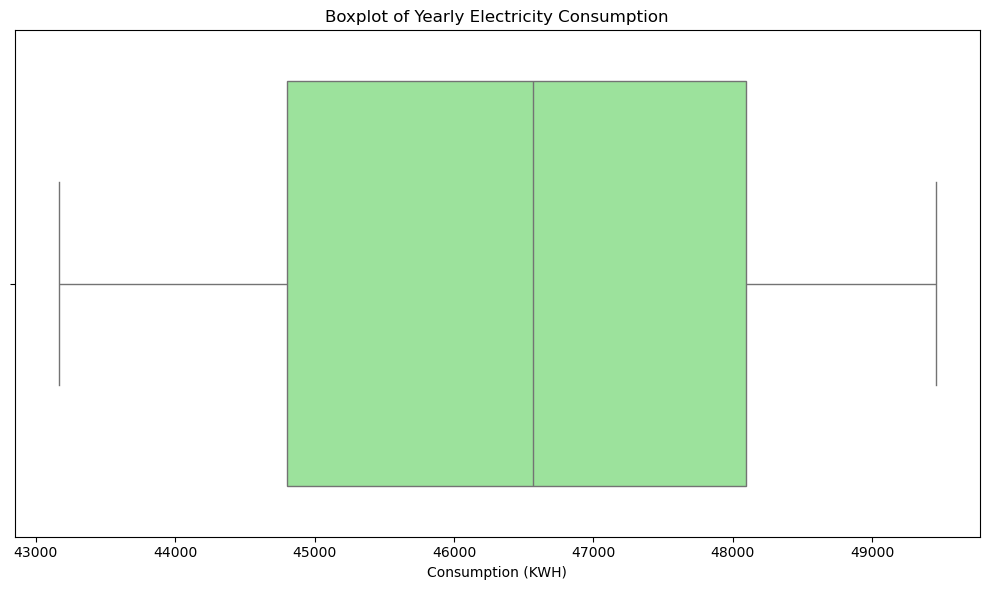

In [20]:
# 1. Line Plot for Monthly Data
plt.figure(figsize=(10, 6))
plt.plot(monthly_df['ds'], monthly_df['y'], marker='o', color='b')
plt.title('Monthly Electricity Consumption in New York City')
plt.xlabel('Date')
plt.ylabel('Consumption (KWH)')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()
plt.tight_layout()  # To ensure everything fits


# 2. Histogram for Monthly Data (with x-axis label)
plt.figure(figsize=(10, 6))
sns.histplot(monthly_df['y'], bins=20, kde=True, color='orange')
plt.title('Histogram of Monthly Electricity Consumption')
plt.xlabel('Consumption (KWH)')
plt.ylabel('Frequency')
plt.tight_layout() 
plt.show()

# 3. Boxplot for Monthly Data (with  x-axis label)
plt.figure(figsize=(10, 6))
sns.boxplot(x=monthly_df['y'], color='lightblue')
plt.title('Boxplot of Monthly Electricity Consumption')
plt.xlabel('Consumption (KWH)')
plt.tight_layout()
plt.show()

# 1. Line Plot for Yearly Data (with proper date formatting on the x-axis)
plt.figure(figsize=(10, 6))
plt.plot(yearly_df['ds'], yearly_df['y'], marker='o', color='green')
plt.title('Yearly Electricity Consumption in New York City')
plt.xlabel('Year')
plt.ylabel('Consumption (KWH)')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()

# 2. Histogram for Yearly Data (with  x-axis label)
plt.figure(figsize=(10, 6))
sns.histplot(yearly_df['y'], bins=10, kde=True, color='purple')
plt.title('Histogram of Yearly Electricity Consumption')
plt.xlabel('Consumption (KWH)')
plt.ylabel('Frequency')
plt.tight_layout() 
plt.show()

# 3. Boxplot for Yearly Data (with  x-axis label)
plt.figure(figsize=(10, 6))
sns.boxplot(x=yearly_df['y'], color='lightgreen')
plt.title('Boxplot of Yearly Electricity Consumption')
plt.xlabel('Consumption (KWH)')
plt.tight_layout() 
plt.show()



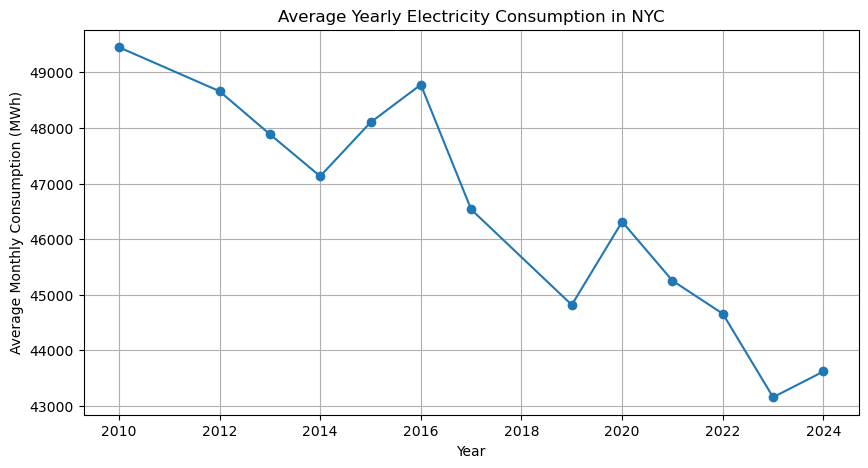

ds
2010    49452.485820
2012    48661.364388
2013    47887.239542
2014    47132.014188
2015    48099.785791
2016    48778.680504
2017    46535.206204
2019    44817.435740
2020    46313.751619
2021    45252.973474
2022    44659.126494
2023    43156.972363
2024    43619.841011
Name: y, dtype: float64


In [21]:
yearly_avg = monthly_df.groupby(monthly_df['ds'].dt.year)['y'].mean()

plt.figure(figsize=(10, 5))
plt.plot(yearly_avg.index, yearly_avg.values, marker='o')
plt.title("Average Yearly Electricity Consumption in NYC")
plt.xlabel("Year")
plt.ylabel("Average Monthly Consumption (MWh)")
plt.grid(True)
plt.show()

print(yearly_avg)


In [22]:
monthly_df['month'] = monthly_df['ds'].dt.month
summer = monthly_df[monthly_df['month'].isin([6, 7, 8])]
summer_avg = summer.groupby(summer['ds'].dt.year)['y'].mean()
print(summer_avg)


ds
2010    64424.558277
2012    62304.909263
2013    60281.882190
2014    56257.306773
2015    58854.950209
2016    62042.329649
2017    56622.681416
2019    54424.599276
2020    59218.289310
2021    55672.084070
2022    55968.864547
2023    51771.428883
2024    56648.165607
Name: y, dtype: float64


In [23]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = monthly_df['y'].quantile(0.25)
Q3 = monthly_df['y'].quantile(0.75)

# Calculate the IQR
IQR = Q3 - Q1

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = monthly_df[(monthly_df['y'] < lower_bound) | (monthly_df['y'] > upper_bound)]

# Display outliers
print("Outliers based on IQR method:")
print(outliers)


Outliers based on IQR method:
           ds             y  month
6  2010-07-01  70574.444748      7
7  2010-08-01  69771.347115      8
18 2012-07-01  71822.707440      7
30 2013-07-01  72616.960183      7
55 2015-08-01  68353.802988      8
66 2016-07-01  67790.812237      7
67 2016-08-01  67872.448389      8


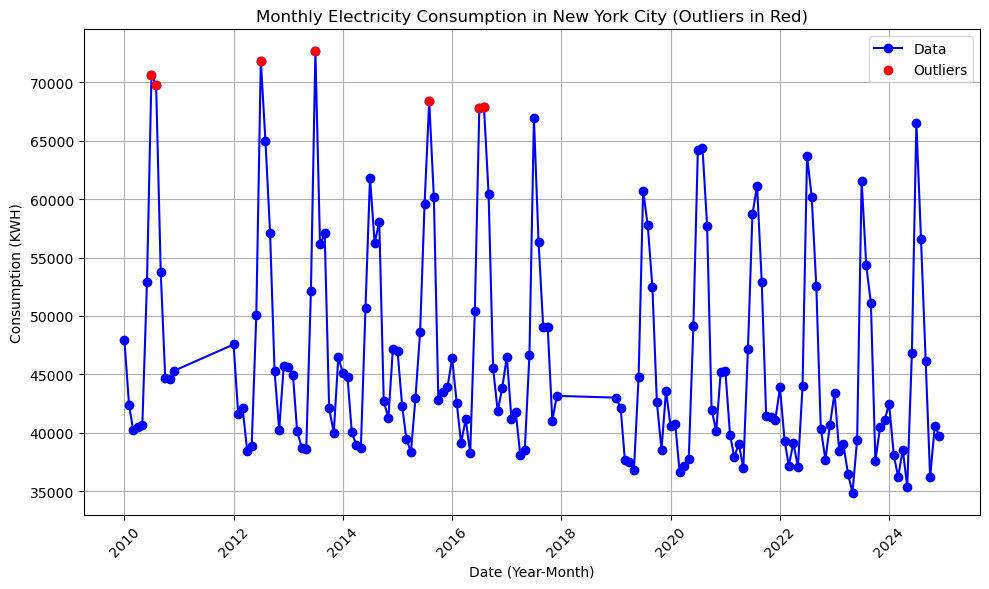

In [24]:

# Plot the data with outliers highlighted
plt.figure(figsize=(10, 6))
plt.plot(monthly_df['ds'], monthly_df['y'], marker='o', color='b', label='Data')
plt.scatter(outliers['ds'], outliers['y'], color='red', label='Outliers', zorder=5)
plt.title('Monthly Electricity Consumption in New York City (Outliers in Red)')
plt.xlabel('Date (Year-Month)')
plt.ylabel('Consumption (KWH)')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [25]:
# Loop through the outliers and replace them with the mean of the surrounding data
"""for index, row in outliers.iterrows():
    # Find the position of the outlier
    outlier_index = monthly_df[monthly_df['ds'] == row['ds']].index[0]
    
    # Find the surrounding indices (previous and next data points)
    prev_index = outlier_index - 1 if outlier_index > 0 else outlier_index
    next_index = outlier_index + 1 if outlier_index < len(monthly_df) - 1 else outlier_index
    
    # Get the surrounding values
    surrounding_data = monthly_df.loc[[prev_index, next_index], 'y']
    
    # Replace the outlier with the mean of the surrounding data
    monthly_df.at[outlier_index, 'y'] = surrounding_data.mean()

# Visualize the cleaned data after replacement
plt.figure(figsize=(10, 6))
plt.plot(monthly_df['ds'], monthly_df['y'], marker='o', color='b')
plt.title('Monthly Electricity Consumption with Outliers Replaced (Mean)')
plt.xlabel('Date (Year-Month)')
plt.ylabel('Consumption (KWH)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()"""


"for index, row in outliers.iterrows():\n    # Find the position of the outlier\n    outlier_index = monthly_df[monthly_df['ds'] == row['ds']].index[0]\n    \n    # Find the surrounding indices (previous and next data points)\n    prev_index = outlier_index - 1 if outlier_index > 0 else outlier_index\n    next_index = outlier_index + 1 if outlier_index < len(monthly_df) - 1 else outlier_index\n    \n    # Get the surrounding values\n    surrounding_data = monthly_df.loc[[prev_index, next_index], 'y']\n    \n    # Replace the outlier with the mean of the surrounding data\n    monthly_df.at[outlier_index, 'y'] = surrounding_data.mean()\n\n# Visualize the cleaned data after replacement\nplt.figure(figsize=(10, 6))\nplt.plot(monthly_df['ds'], monthly_df['y'], marker='o', color='b')\nplt.title('Monthly Electricity Consumption with Outliers Replaced (Mean)')\nplt.xlabel('Date (Year-Month)')\nplt.ylabel('Consumption (KWH)')\nplt.grid(True)\nplt.xticks(rotation=45)\nplt.tight_layout()\nplt.sho

In [26]:
monthly_df['year'] = monthly_df['ds'].dt.year
monthly_df.groupby('year').size()

year
2010    12
2012    12
2013    12
2014    12
2015    12
2016    12
2017    12
2019    12
2020    12
2021    12
2022    12
2023    12
2024    12
dtype: int64

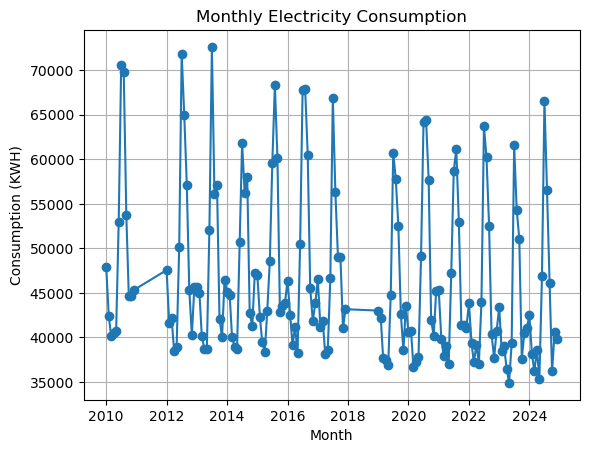

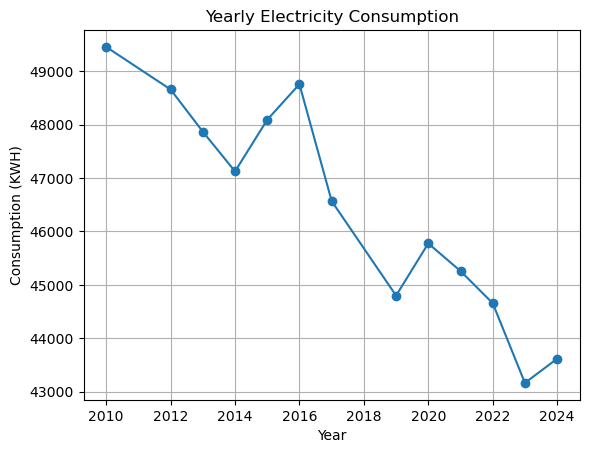

In [27]:
plt.plot(monthly_df['ds'], monthly_df['y'], marker='o')
plt.title('Monthly Electricity Consumption')
plt.xlabel('Month')
plt.ylabel('Consumption (KWH)')
plt.grid(True)
plt.show()

plt.plot(yearly_df['ds'], yearly_df['y'], marker='o')
plt.title('Yearly Electricity Consumption')
plt.xlabel('Year')
plt.ylabel('Consumption (KWH)')
plt.grid(True)
plt.show()

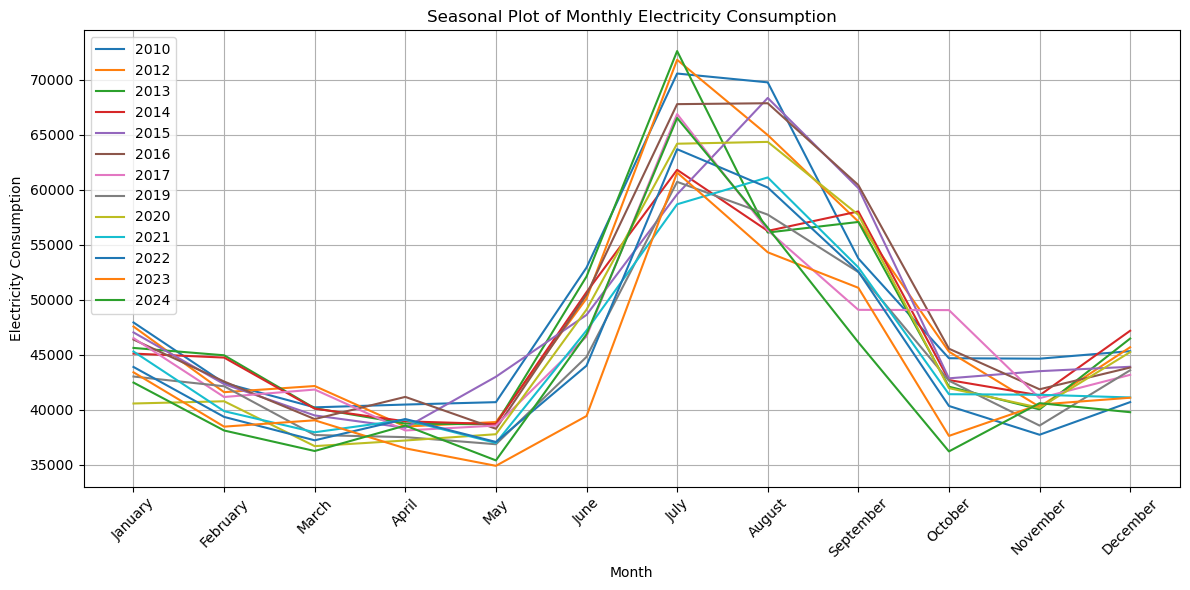

In [28]:
# Ensure dataframe has datetime and energy usage
monthly_df['year'] = monthly_df['ds'].dt.year
monthly_df['month'] = monthly_df['ds'].dt.month_name()

# Order months so they appear Jan–Dec
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']

plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_df, x='month', y='y', hue='year', palette='tab10', 
             hue_order=sorted(monthly_df['year'].unique()))
plt.legend(loc='upper left')
plt.title("Seasonal Plot of Monthly Electricity Consumption")
plt.xlabel("Month")
plt.ylabel("Electricity Consumption")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()


# The ACF (Autocorrelation Function) 
plot to check how much the data is related to its past values.
Here, the ACF plot helps discover patterns in the original data.
High lines at lags like 12, 24, 36 → There’s a pattern every year → Add yearly seasonality to your Prophet model.

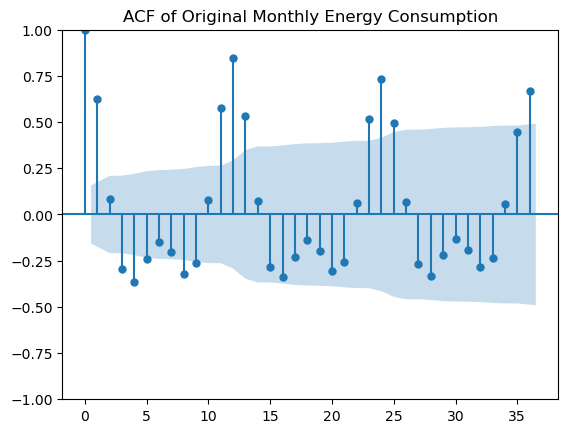

In [29]:
from statsmodels.graphics.tsaplots import plot_acf

# Original data
plot_acf(monthly_df['y'], lags=36)
plt.title('ACF of Original Monthly Energy Consumption')
plt.show()

# Building the Prophet Model

In [30]:
def detect_time_unit(df):
    if 'ds' not in df.columns:
        raise ValueError("DataFrame must contain 'ds' column")
    
    # Check frequency by examining date differences
    date_diffs = df['ds'].sort_values().diff().dropna()
    median_days = date_diffs.median().days
    
    if median_days < 40:  # Approximately monthly
        return 'monthly'
    elif median_days > 300:  # Approximately yearly
        return 'yearly'
    else:
        return 'unknown'


In [31]:
def evaluate_model(actual, predicted):
    """
    Evaluate model performance with appropriate metrics.
    
    Parameters:
    actual : array-like. The actual values
    predicted : array-like. The predicted values
        
    Returns:
    tuple
    (MAE, MAPE, R²)
    """
    # Ensure both actual and predicted have the same length
    if len(actual) != len(predicted):
        raise ValueError(f"Length mismatch: actual has {len(actual)} values, predicted has {len(predicted)} values.")
    
    mae = mean_absolute_error(actual, predicted)
    mape = mean_absolute_percentage_error(actual, predicted) * 100  # Percentage
    r2 = r2_score(actual, predicted)
    
    return mae, mape, r2


In [32]:
def forecast_monthly(df, m):
    # Forecast future months
    future_1 = m.make_future_dataframe(periods=1, freq='M')
    future_6 = m.make_future_dataframe(periods=6, freq='M')
    future_9 = m.make_future_dataframe(periods=9, freq='M')

    # Make predictions
    forecast_1 = m.predict(future_1)
    forecast_6 = m.predict(future_6)
    forecast_9 = m.predict(future_9)

    return forecast_1, forecast_6, forecast_9

def forecast_yearly(df, m):
    # Forecast future years
    future_1 = m.make_future_dataframe(periods=1, freq='Y')
    future_10 = m.make_future_dataframe(periods=10, freq='Y')
    future_20 = m.make_future_dataframe(periods=20, freq='Y')

    # Make predictions
    forecast_1 = m.predict(future_1)
    forecast_10 = m.predict(future_10)
    forecast_20 = m.predict(future_20)

    return forecast_1, forecast_10, forecast_20


In [33]:
def plot_forecasts(m, forecast, title):
    fig = m.plot(forecast)
    plt.title(title)
    plt.show()


In [34]:
def forecast_consumption(df):
    # Ensure we have the required columns
    if 'ds' not in df.columns or 'y' not in df.columns:
        raise ValueError("DataFrame must contain 'ds' and 'y' columns")

    time_unit = detect_time_unit(df)
    print(f"Detected time unit: {time_unit}")

    # Initialize Prophet model
    m = Prophet()
    m.fit(df)

    if time_unit == 'monthly':
        forecast_1, forecast_6, forecast_9 = forecast_monthly(df, m)

        plot_forecasts(m, forecast_1, '1-Month Forecast')
        plot_forecasts(m, forecast_6, '6-Month Forecast')
        plot_forecasts(m, forecast_9, '9-Month Forecast')

        display_forecast_tabular(forecast_1, '1-Month Forecast Predictions')
        display_forecast_tabular(forecast_6, '6-Month Forecast Predictions')
        display_forecast_tabular(forecast_9, '9-Month Forecast Predictions')

        forecast_1_renamed = forecast_1[['ds', 'yhat']].rename(columns={'yhat': '1-month'}) # Rename after plotting
        forecast_6_renamed = forecast_6[['ds', 'yhat']].rename(columns={'yhat': '6-month'}) # Rename after plotting
        forecast_9_renamed = forecast_9[['ds', 'yhat']].rename(columns={'yhat': '9-month'}) # Rename after plotting

        return forecast_1_renamed, forecast_6_renamed, forecast_9_renamed # Return the DataFrames

    elif time_unit == 'yearly':
        forecast_1, forecast_10, forecast_20 = forecast_yearly(df, m) # Corrected call

        plot_forecasts(m, forecast_1, '1-Year Forecast')
        plot_forecasts(m, forecast_10, '10-Year Forecast')
        plot_forecasts(m, forecast_20, '20-Year Forecast')

        display_forecast_tabular(forecast_1, '1-Year Forecast Predictions')
        display_forecast_tabular(forecast_10, '10-Year Forecast Predictions')
        display_forecast_tabular(forecast_20, '20-Year Forecast Predictions')

        forecast_1_renamed = forecast_1[['ds', 'yhat']].rename(columns={'yhat': '1-year'}) # Rename after plotting
        forecast_10_renamed = forecast_10[['ds', 'yhat']].rename(columns={'yhat': '10-year'}) # Rename after plotting
        forecast_20_renamed = forecast_20[['ds', 'yhat']].rename(columns={'yhat': '20-year'}) # Rename after plotting

        return forecast_1_renamed, forecast_10_renamed, forecast_20_renamed # Return the DataFrames

    else:
        raise ValueError(f"Unsupported time unit: {time_unit}")

def display_forecast_tabular(forecast_df, title):
    """Displays the forecast in a tabular format."""
    print(f"\n--- {title} ---")
    print(forecast_df[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

20:19:55 - cmdstanpy - INFO - Chain [1] start processing
20:19:55 - cmdstanpy - INFO - Chain [1] done processing


Detected time unit: monthly


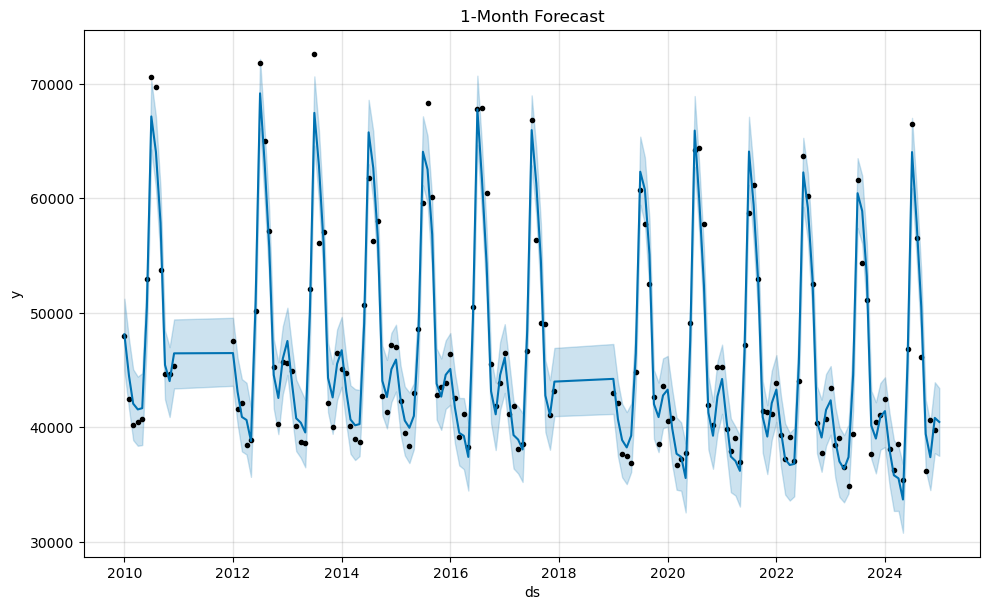

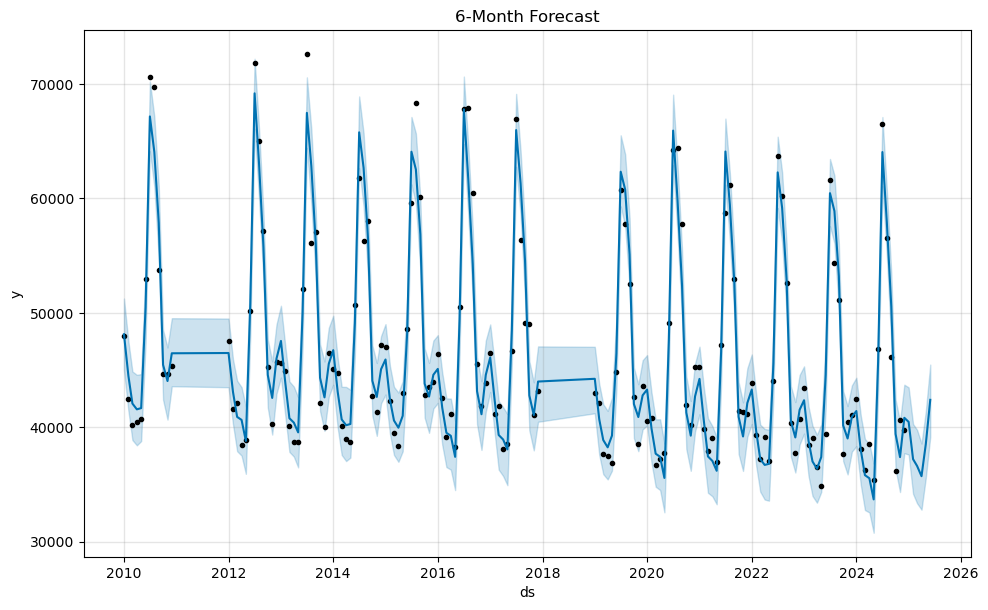

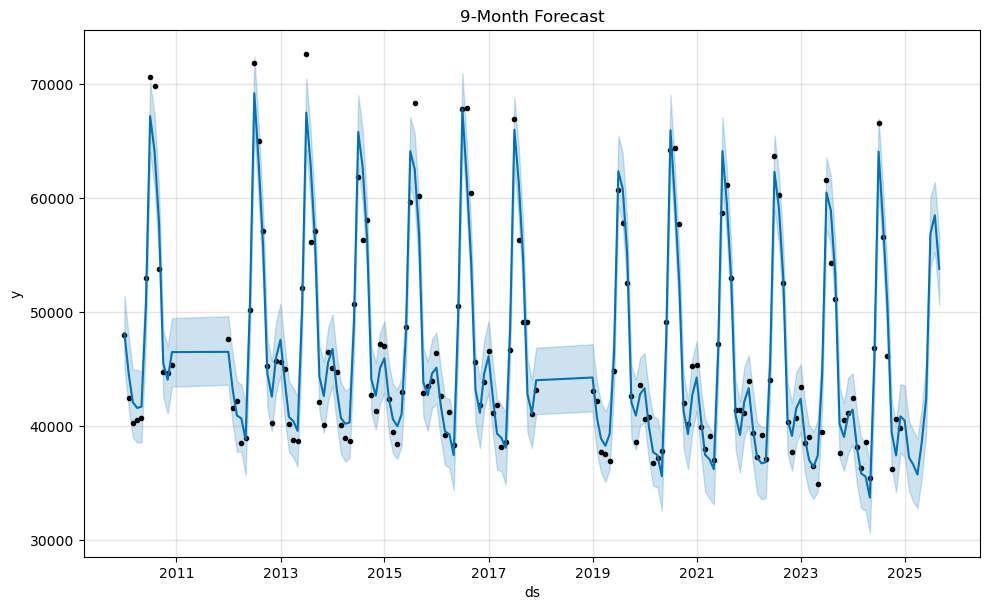

20:19:55 - cmdstanpy - INFO - Chain [1] start processing
20:19:55 - cmdstanpy - INFO - Chain [1] done processing



--- 1-Month Forecast Predictions ---
          ds          yhat    yhat_lower    yhat_upper
0 2010-01-01  48119.362161  44944.717059  51233.274889
1 2010-02-01  44482.435515  41614.650149  47697.441486
2 2010-03-01  42064.750810  38879.277362  45063.651161
3 2010-04-01  41560.058377  38382.331517  44425.945079
4 2010-05-01  41665.741547  38447.197888  44721.542725

--- 6-Month Forecast Predictions ---
          ds          yhat    yhat_lower    yhat_upper
0 2010-01-01  48119.362161  44984.678009  51244.462202
1 2010-02-01  44482.435515  41422.455810  47491.069888
2 2010-03-01  42064.750810  38874.523260  44867.601432
3 2010-04-01  41560.058377  38416.621279  44576.164678
4 2010-05-01  41665.741547  38785.736835  44637.869709

--- 9-Month Forecast Predictions ---
          ds          yhat    yhat_lower    yhat_upper
0 2010-01-01  48119.362161  45134.759010  51375.299974
1 2010-02-01  44482.435515  41455.775455  47692.576099
2 2010-03-01  42064.750810  38988.423563  44893.806790
3 2010

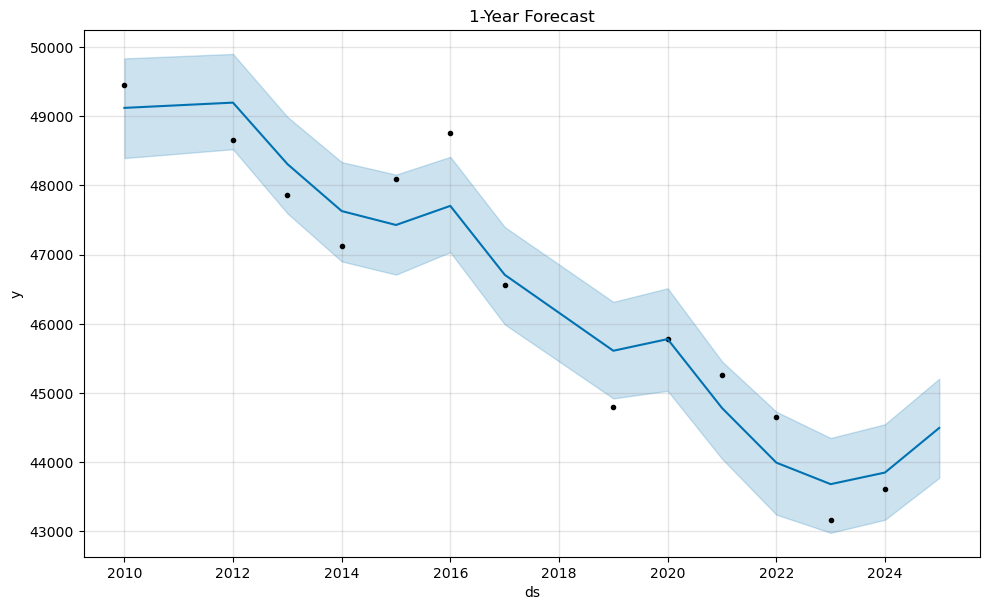

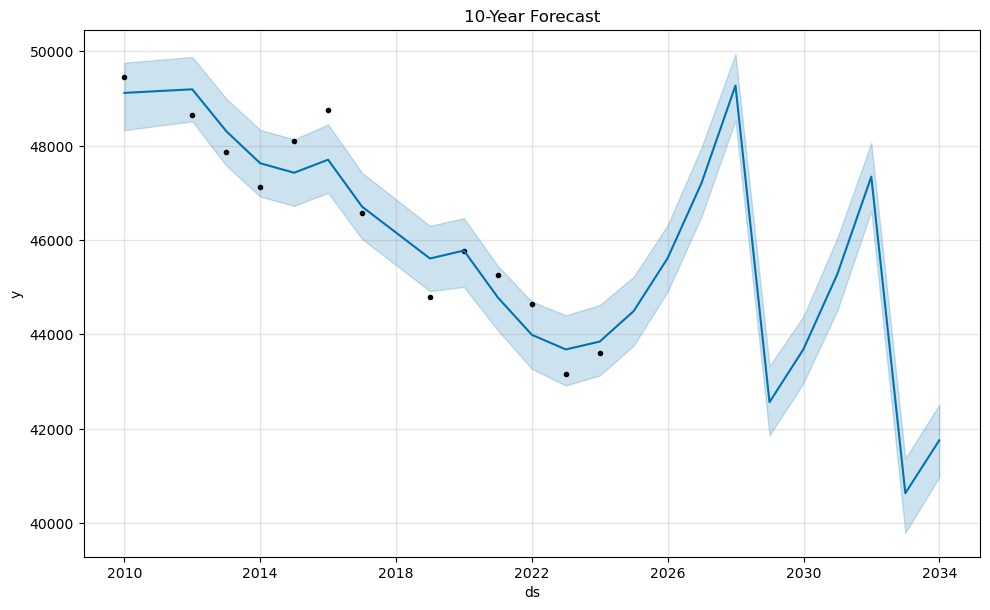

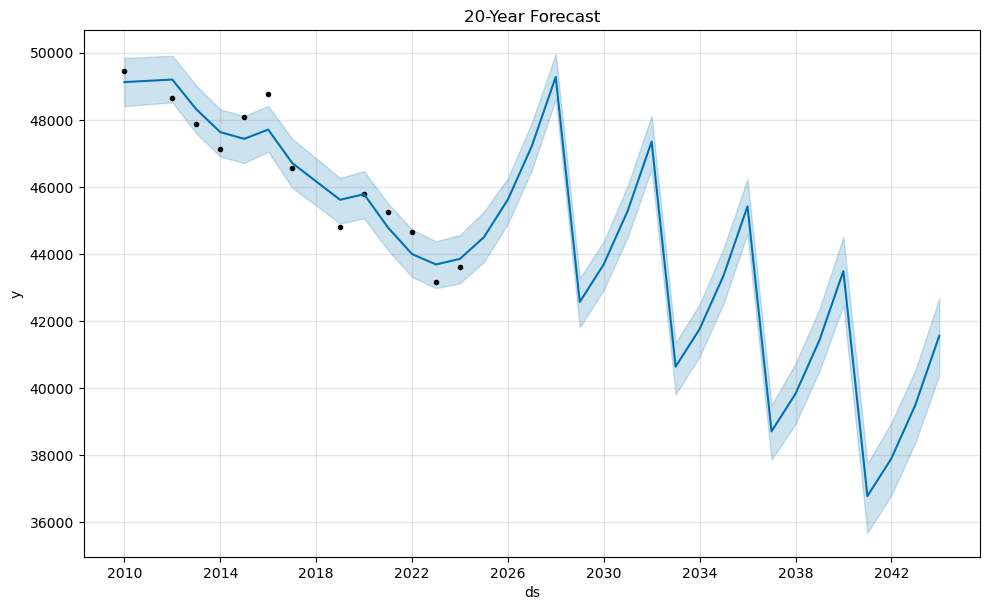


--- 1-Year Forecast Predictions ---
          ds          yhat    yhat_lower    yhat_upper
0 2010-01-01  49120.884061  48395.265359  49835.882810
1 2012-01-01  49196.893023  48523.616660  49900.527583
2 2013-01-01  48308.772815  47596.407201  48990.835431
3 2014-01-01  47629.424339  46901.937535  48337.443162
4 2015-01-01  47428.280402  46710.380133  48156.184577

--- 10-Year Forecast Predictions ---
          ds          yhat    yhat_lower    yhat_upper
0 2010-01-01  49120.884061  48329.921895  49762.222710
1 2012-01-01  49196.893023  48518.423543  49882.008329
2 2013-01-01  48308.772815  47578.595122  48999.023493
3 2014-01-01  47629.424339  46921.176376  48335.674639
4 2015-01-01  47428.280402  46726.936980  48138.452905

--- 20-Year Forecast Predictions ---
          ds          yhat    yhat_lower    yhat_upper
0 2010-01-01  49120.884061  48402.303259  49839.839822
1 2012-01-01  49196.893023  48517.540408  49905.957987
2 2013-01-01  48308.772815  47588.730520  49014.608083
3 2014-

In [35]:
forecast_1m, forecast_6m, forecast_9m = forecast_consumption(monthly_df)
forecast_1y, forecast_10y, forecast_20y = forecast_consumption(yearly_df)

# Model Evaluation

In [36]:
print("Monthly Forecast Evaluations:")

# List of forecasts: (label, months back, forecast dataframe)
forecasts = [
    ("1-month", 3, forecast_1m),  # using 3 months of data to evaluate 1-month forecast
    ("6-month", 6, forecast_6m),
    ("9-month", 9, forecast_9m)
]

# Get the last date from actual monthly data
latest_date = monthly_df['ds'].max()

# Loop through each forecast type
for label, months_back, forecast_df in forecasts:
    # Go back N months from the latest date to define the start of evaluation
    start_date = latest_date - pd.DateOffset(months=months_back)
    
    # Get actual values between start_date and latest_date
    actual_data = monthly_df[(monthly_df['ds'] > start_date) & (monthly_df['ds'] <= latest_date)]
    actual_values = actual_data['y'].values

    # Get predicted values for the same period
    predicted_data = forecast_df[(forecast_df['ds'] > start_date) & (forecast_df['ds'] <= latest_date)]
    predicted_values = predicted_data[label].values

    # Make sure we have matching lengths
    if len(actual_values) > 0 and len(predicted_values) > 0:
        # MAE: Mean Absolute Error
        mae = abs(actual_values - predicted_values).mean()

        # MAPE: Mean Absolute Percentage Error
        mape = (abs((actual_values - predicted_values) / actual_values) * 100).mean()

        # R² (Coefficient of Determination)
        if len(actual_values) > 1:
            y_mean = actual_values.mean()
            ss_total = ((actual_values - y_mean) ** 2).sum()
            ss_residual = ((actual_values - predicted_values) ** 2).sum()
            r2 = 1 - (ss_residual / ss_total)
        else:
            r2 = "Not enough data for R²"

        # Print results
        print(f"\n{label} Forecast Evaluation:")
        print(f"MAE: {mae}")
        print(f"MAPE: {mape} %")
        print(f"R²: {r2}")
    else:
        print(f"\nNot enough data to evaluate the {label} forecast.")


Monthly Forecast Evaluations:

1-month Forecast Evaluation:
MAE: 2482.8906441701497
MAPE: 6.451107573813931 %
R²: -0.9854982248314514

6-month Forecast Evaluation:
MAE: 2615.2433027639527
MAPE: 5.838718811456793 %
R²: 0.9279170695904626

9-month Forecast Evaluation:
MAE: 2397.8978417689223
MAPE: 5.574072035625904 %
R²: 0.9273015529579205


In [37]:
print("\nYearly Forecast Evaluations:")

# List of forecasts: (label, how many years back, forecast dataframe)
forecasts = [
    ("1-year", 3, forecast_1y),
    ("10-year", 10, forecast_10y),
    ("20-year", 20, forecast_20y)
]

# Get the most recent date in the actual yearly data
latest_date = yearly_df['ds'].max()

# Loop through each forecast type
for label, years_back, forecast_df in forecasts:
    # Define the starting point for evaluation
    start_date = latest_date - pd.DateOffset(years=years_back)

    # Get actual and predicted values from that range
    actual = yearly_df[yearly_df['ds'] > start_date]['y'].values
    predicted = forecast_df[
        (forecast_df['ds'] > start_date) &
        (forecast_df['ds'] <= latest_date)
    ][label].values

    # Only evaluate if there's data to compare
    if len(actual) > 0 and len(predicted) > 0:
        mae, mape, r2 = evaluate_model(actual, predicted)
        print(f"\n{label} Forecast:")
        print(f"MAE: {mae}")
        print(f"MAPE: {mape}%")
        print(f"R²: {r2}")
    else:
        print(f"\nNot enough data to evaluate the {label} Forecast.")



Yearly Forecast Evaluations:

1-year Forecast:
MAE: 471.6407543936851
MAPE: 1.0736878665681646%
R²: 0.3483188935500966

10-year Forecast:
MAE: 506.9914403231742
MAPE: 1.103650319807322%
R²: 0.8877101194214532

20-year Forecast:
MAE: 490.82829899529145
MAPE: 1.0543368601890892%
R²: 0.9203337375817077


# Tuning FBProphet model on the following parameters: Forecasting growth. Seasonality. Trend. 

In [38]:
def train_predict_model(df, growth_type='linear', seasonality_params=None, 
                        n_changepoints=25, changepoint_prior_scale=0.05, 
                        forecast_periods=12):  # Add forecast_periods as a parameter
    model = Prophet(growth=growth_type, 
                    n_changepoints=n_changepoints, 
                    changepoint_prior_scale=changepoint_prior_scale)

    if seasonality_params:
        for params in seasonality_params:
            model.add_seasonality(name=params['name'], 
                                  period=params['period'], 
                                  fourier_order=params['fourier_order'])

    if growth_type == 'logistic' and 'cap' not in df.columns:
        raise ValueError("DataFrame must contain 'cap' column for logistic growth.")

    model.fit(df)
    future = model.make_future_dataframe(periods=forecast_periods, freq='MS')  # MS = Month Start
    # THIS LINE IS CRITICAL
    if growth_type == 'logistic':
        future['cap'] = df['cap'].iloc[0]  # Use same cap value as training data

    forecast = model.predict(future)
    return forecast, model


# Forecasting Growth

In [39]:
# Linear growth
forecast_linear, model_linear = train_predict_model(monthly_df, growth_type='linear',forecast_periods=120)
print("\nLinear Growth Forecast:")
print(forecast_linear[['ds', 'yhat']].head())

# Logistic growth (requires a 'cap' column in monthly_df)
historical_max = monthly_df['y'].max()
estimated_capacity = historical_max * 1.2
monthly_df['cap'] = estimated_capacity

print("Columns in monthly_df before logistic fit:")
print(monthly_df.columns)

if 'cap' in monthly_df.columns:
    forecast_logistic, model_logistic = train_predict_model(monthly_df.copy(), growth_type='logistic',forecast_periods=120) 
    print("\nLogistic Growth Forecast:")
    print(forecast_logistic[['ds', 'yhat']].head())
else:
    print("\n'cap' column not found in monthly_df, skipping logistic growth.")

# Flat growth
forecast_flat, model_flat = train_predict_model(monthly_df, growth_type='flat',forecast_periods=120)
print("\nFlat Growth Forecast:")
print(forecast_flat[['ds', 'yhat']].head())

20:20:03 - cmdstanpy - INFO - Chain [1] start processing
20:20:03 - cmdstanpy - INFO - Chain [1] done processing
20:20:03 - cmdstanpy - INFO - Chain [1] start processing
20:20:03 - cmdstanpy - INFO - Chain [1] done processing
20:20:03 - cmdstanpy - INFO - Chain [1] start processing
20:20:03 - cmdstanpy - INFO - Chain [1] done processing



Linear Growth Forecast:
          ds          yhat
0 2010-01-01  48119.362161
1 2010-02-01  44482.435515
2 2010-03-01  42064.750810
3 2010-04-01  41560.058377
4 2010-05-01  41665.741547
Columns in monthly_df before logistic fit:
Index(['ds', 'y', 'month', 'year', 'cap'], dtype='object')

Logistic Growth Forecast:
          ds          yhat
0 2010-01-01  48422.426909
1 2010-02-01  44816.980390
2 2010-03-01  42376.489532
3 2010-04-01  41862.202074
4 2010-05-01  41922.492257

Flat Growth Forecast:
          ds          yhat
0 2010-01-01  45322.482179
1 2010-02-01  41660.103638
2 2010-03-01  39229.647846
3 2010-04-01  38720.845770
4 2010-05-01  38738.465357


In [40]:
def evaluate_forecast(forecast_df, actual_df, label=""):
    """Evaluate forecast with MAE, MAPE, and R²."""
    merged = actual_df[['ds', 'y']].merge(forecast_df[['ds', 'yhat']], on='ds')
    mae = mean_absolute_error(merged['y'], merged['yhat'])
    mape = mean_absolute_percentage_error(merged['y'], merged['yhat']) * 100
    r2 = r2_score(merged['y'], merged['yhat'])
    print(f"{label} - MAE: {mae:.2f}, MAPE: {mape:.2f}%, R²: {r2:.3f}")

# Linear growth
forecast_linear, model_linear = train_predict_model(monthly_df, growth_type='linear', forecast_periods=120)
print("\nLinear Growth Forecast:")
print(forecast_linear[['ds', 'yhat']].head())
evaluate_forecast(forecast_linear, monthly_df, "Linear Growth")

# Logistic growth (requires a 'cap' column in monthly_df)
historical_max = monthly_df['y'].max()
estimated_capacity = historical_max * 1.2
monthly_df['cap'] = estimated_capacity

print("Columns in monthly_df before logistic fit:")
print(monthly_df.columns)

if 'cap' in monthly_df.columns:
    forecast_logistic, model_logistic = train_predict_model(monthly_df.copy(), growth_type='logistic', forecast_periods=120) 
    print("\nLogistic Growth Forecast:")
    print(forecast_logistic[['ds', 'yhat']].head())
    evaluate_forecast(forecast_logistic, monthly_df, "Logistic Growth")
else:
    print("\n'cap' column not found in monthly_df, skipping logistic growth.")

# Flat growth
forecast_flat, model_flat = train_predict_model(monthly_df, growth_type='flat', forecast_periods=120)
print("\nFlat Growth Forecast:")
print(forecast_flat[['ds', 'yhat']].head())
evaluate_forecast(forecast_flat, monthly_df, "Flat Growth")


20:20:04 - cmdstanpy - INFO - Chain [1] start processing
20:20:04 - cmdstanpy - INFO - Chain [1] done processing
20:20:04 - cmdstanpy - INFO - Chain [1] start processing
20:20:04 - cmdstanpy - INFO - Chain [1] done processing
20:20:04 - cmdstanpy - INFO - Chain [1] start processing
20:20:04 - cmdstanpy - INFO - Chain [1] done processing



Linear Growth Forecast:
          ds          yhat
0 2010-01-01  48119.362161
1 2010-02-01  44482.435515
2 2010-03-01  42064.750810
3 2010-04-01  41560.058377
4 2010-05-01  41665.741547
Linear Growth - MAE: 1797.93, MAPE: 3.73%, R²: 0.933
Columns in monthly_df before logistic fit:
Index(['ds', 'y', 'month', 'year', 'cap'], dtype='object')

Logistic Growth Forecast:
          ds          yhat
0 2010-01-01  48422.426909
1 2010-02-01  44816.980390
2 2010-03-01  42376.489532
3 2010-04-01  41862.202074
4 2010-05-01  41922.492257
Logistic Growth - MAE: 1809.60, MAPE: 3.75%, R²: 0.933

Flat Growth Forecast:
          ds          yhat
0 2010-01-01  45322.482179
1 2010-02-01  41660.103638
2 2010-03-01  39229.647846
3 2010-04-01  38720.845770
4 2010-05-01  38738.465357
Flat Growth - MAE: 2291.95, MAPE: 4.78%, R²: 0.893


The Linear Growth and Logistic Growth models are quite similar in performance. 
They both have MAE values close to each other, and their R² values are also almost the same,
meaning they explain a similar proportion of the variance in the data. 
The Linear Growth model has a slightly better MAPE and R².

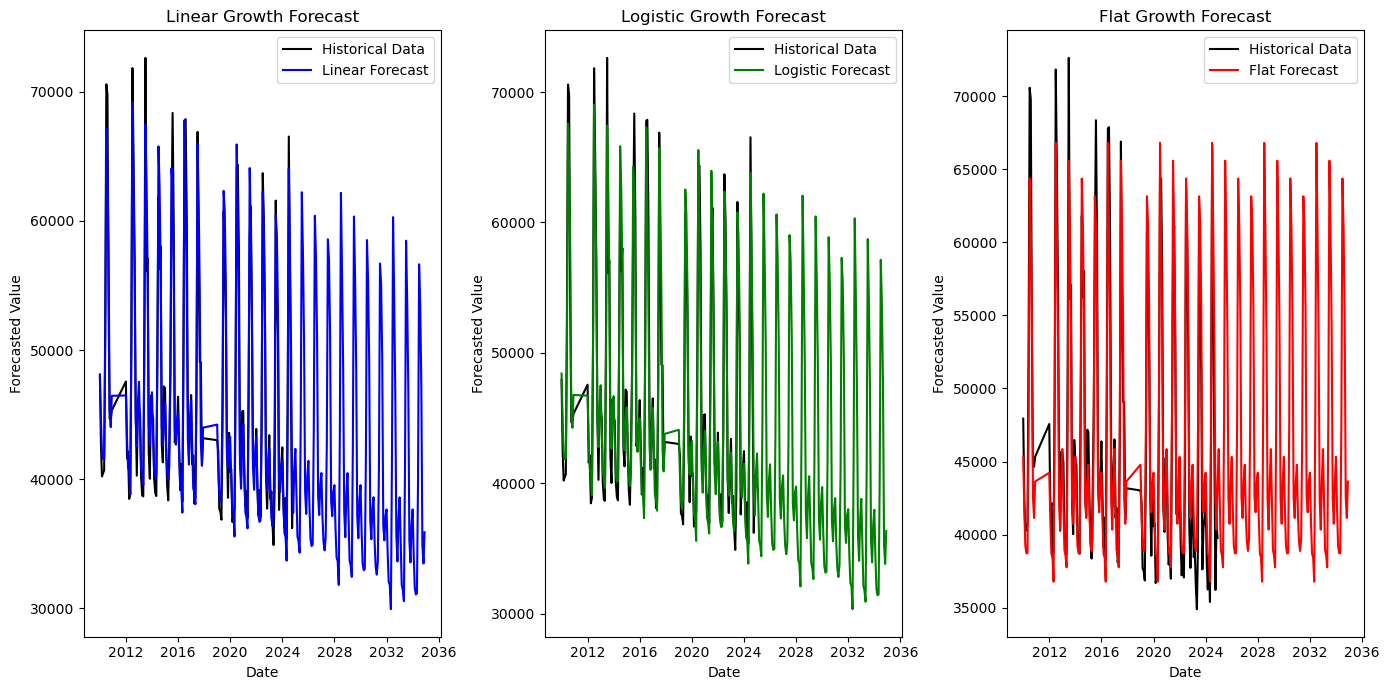

In [41]:
# Plotting the results with both historical and future data
plt.figure(figsize=(14, 7))

# Plot linear growth forecast with both historical and future data
plt.subplot(1, 3, 1)
plt.plot(monthly_df['ds'], monthly_df['y'], label='Historical Data', color='black')
plt.plot(forecast_linear['ds'], forecast_linear['yhat'], label='Linear Forecast', color='blue')
plt.title('Linear Growth Forecast')
plt.xlabel('Date')
plt.ylabel('Forecasted Value')
plt.legend()

# Plot logistic growth forecast with both historical and future data
if 'cap' in monthly_df.columns:
    plt.subplot(1, 3, 2)
    plt.plot(monthly_df['ds'], monthly_df['y'], label='Historical Data', color='black')
    plt.plot(forecast_logistic['ds'], forecast_logistic['yhat'], label='Logistic Forecast', color='green')
    plt.title('Logistic Growth Forecast')
    plt.xlabel('Date')
    plt.ylabel('Forecasted Value')
    plt.legend()

# Plot flat growth forecast with both historical and future data
plt.subplot(1, 3, 3)
plt.plot(monthly_df['ds'], monthly_df['y'], label='Historical Data', color='black')
plt.plot(forecast_flat['ds'], forecast_flat['yhat'], label='Flat Forecast', color='red')
plt.title('Flat Growth Forecast')
plt.xlabel('Date')
plt.ylabel('Forecasted Value')
plt.legend()

plt.tight_layout()
plt.show()

# Seasonality

20:21:20 - cmdstanpy - INFO - Chain [1] start processing
20:21:20 - cmdstanpy - INFO - Chain [1] done processing



Forecast with Monthly Seasonality:
          ds          yhat
0 2010-01-01  47130.866434
1 2010-02-01  42771.131741
2 2010-03-01  42198.830434
3 2010-04-01  41513.929372
4 2010-05-01  41700.139520


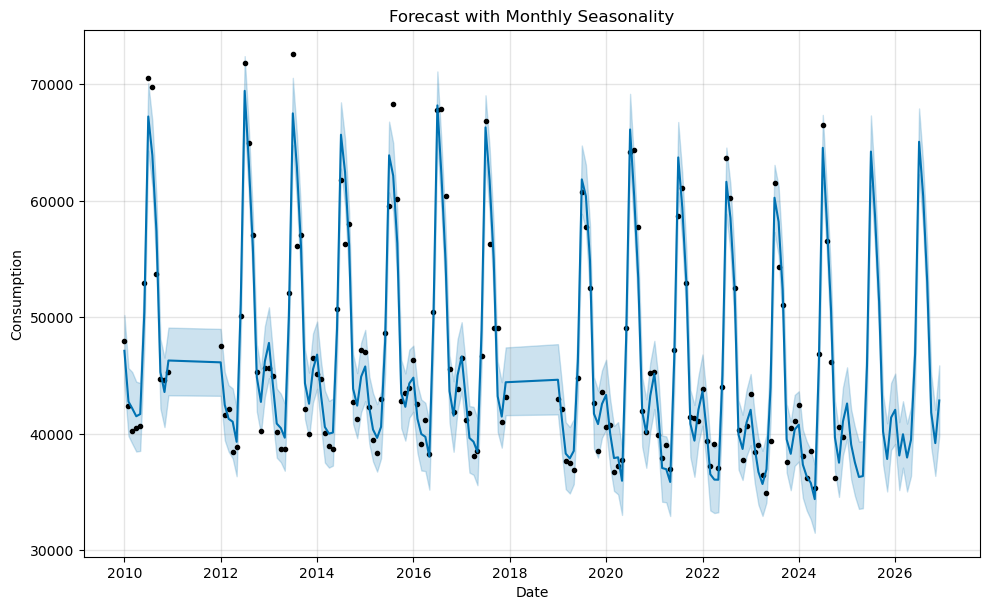

20:21:20 - cmdstanpy - INFO - Chain [1] start processing
20:21:20 - cmdstanpy - INFO - Chain [1] done processing



Forecast with Yearly Seasonality:
          ds          yhat
0 2010-01-01  47229.562584
1 2010-02-01  44908.675066
2 2010-03-01  41285.172120
3 2010-04-01  42126.090031
4 2010-05-01  40403.357701


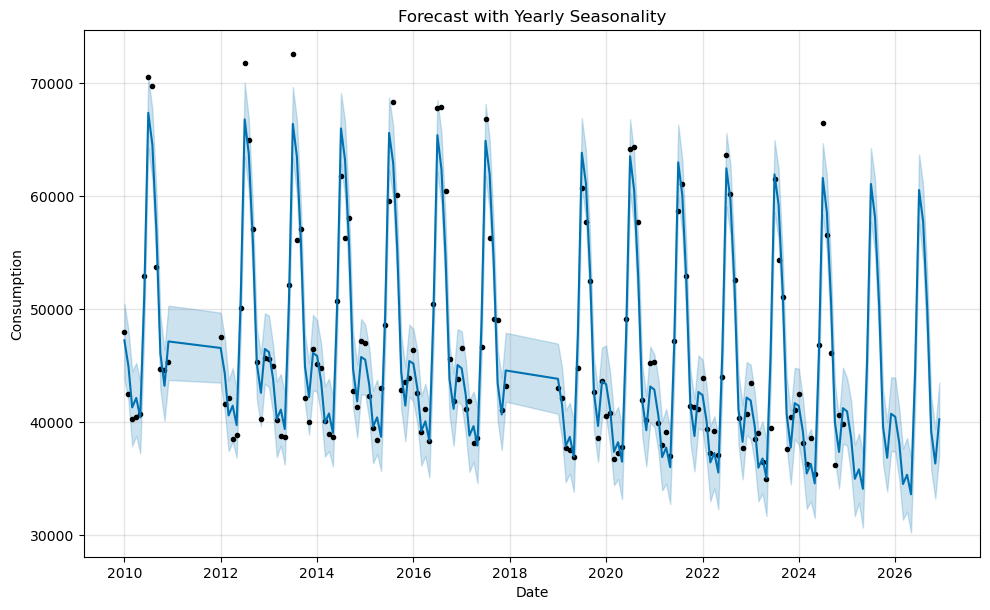

20:21:20 - cmdstanpy - INFO - Chain [1] start processing
20:21:20 - cmdstanpy - INFO - Chain [1] done processing



Forecast with Monthly + Yearly Seasonality:
          ds          yhat
0 2010-01-01  46543.161985
1 2010-02-01  43815.670419
2 2010-03-01  41177.112438
3 2010-04-01  42100.697074
4 2010-05-01  40288.151474


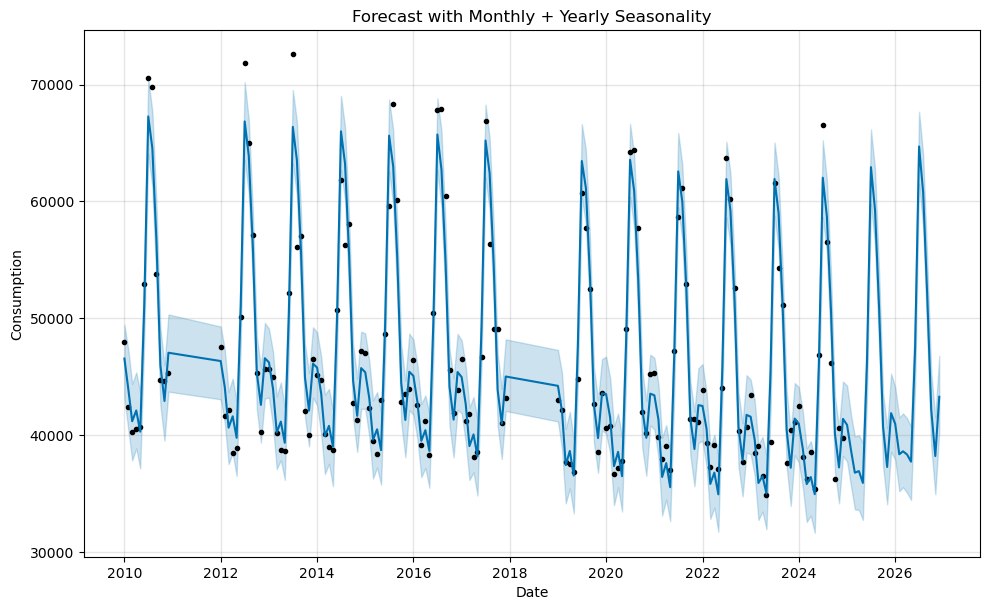

20:21:20 - cmdstanpy - INFO - Chain [1] start processing
20:21:20 - cmdstanpy - INFO - Chain [1] done processing



Forecast with Weekly Seasonality:
          ds          yhat
0 2010-01-01  47896.795845
1 2010-02-01  45093.416200
2 2010-03-01  42787.365781
3 2010-04-01  40547.761087
4 2010-05-01  42359.134011


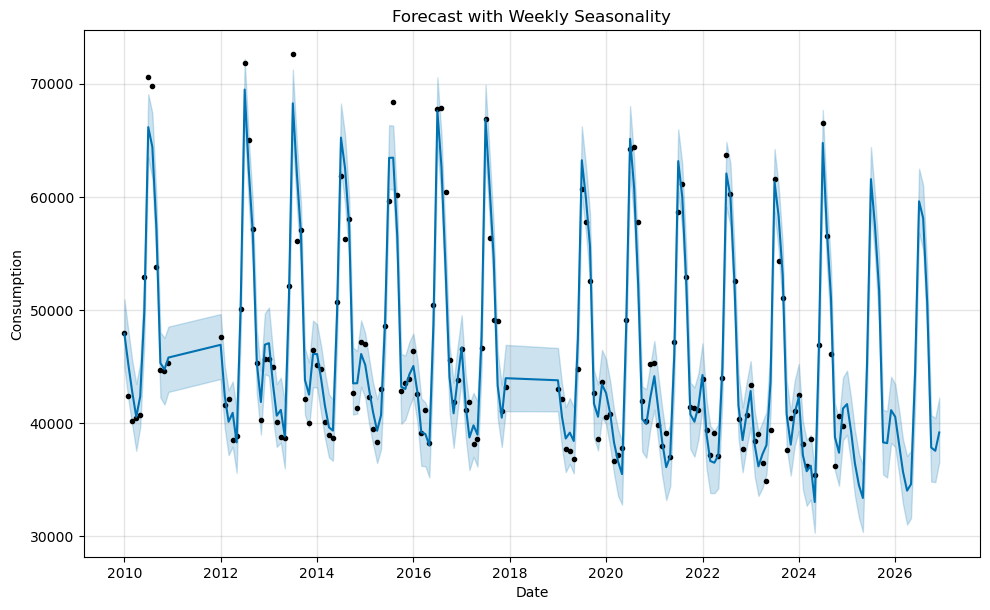

In [43]:
def plot_forecast(model, forecast, title):
    fig = model.plot(forecast)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Consumption")
    plt.show()

# Model setups
seasonalities = {
    'Monthly': [{'name': 'monthly', 'period': 30.5, 'fourier_order': 3}],
    'Yearly': [{'name': 'yearly', 'period': 365.25, 'fourier_order': 5}],
    'Monthly + Yearly': [
        {'name': 'monthly', 'period': 30.5, 'fourier_order': 3},
        {'name': 'yearly', 'period': 365.25, 'fourier_order': 5}
    ],
    'Weekly': [{'name': 'weekly', 'period': 7, 'fourier_order': 4}]
}

# Run models and plot
for title, seas in seasonalities.items():
    forecast, model = train_predict_model(
        monthly_df,
        seasonality_params=seas,
        forecast_periods=24
    )
    print(f"\nForecast with {title} Seasonality:")
    print(forecast[['ds', 'yhat']].head())
    plot_forecast(model, forecast, f"Forecast with {title} Seasonality")


20:21:27 - cmdstanpy - INFO - Chain [1] start processing
20:21:27 - cmdstanpy - INFO - Chain [1] done processing
20:21:27 - cmdstanpy - INFO - Chain [1] start processing
20:21:27 - cmdstanpy - INFO - Chain [1] done processing
20:21:27 - cmdstanpy - INFO - Chain [1] start processing
20:21:27 - cmdstanpy - INFO - Chain [1] done processing
20:21:27 - cmdstanpy - INFO - Chain [1] start processing
20:21:27 - cmdstanpy - INFO - Chain [1] done processing


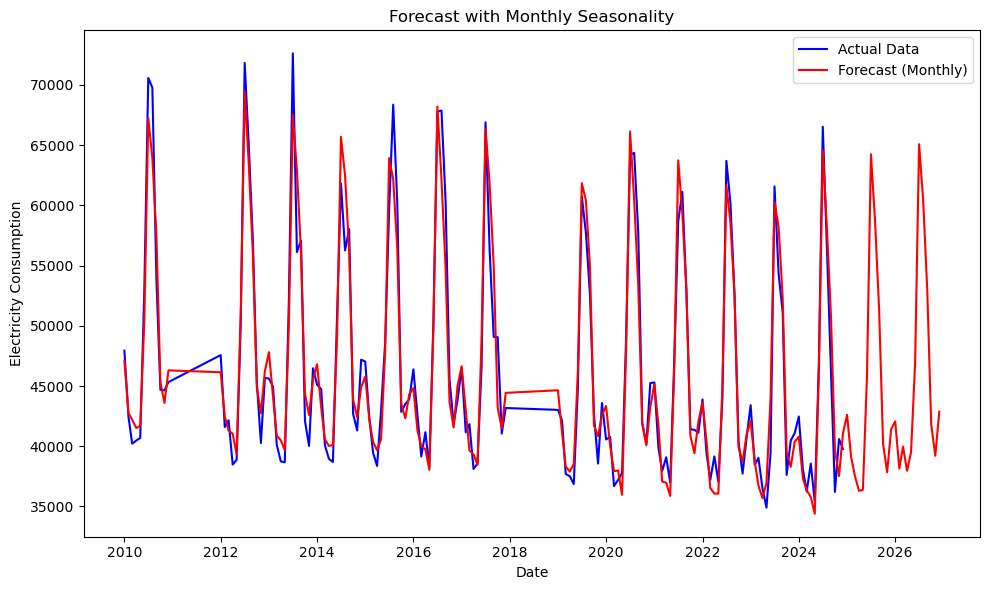

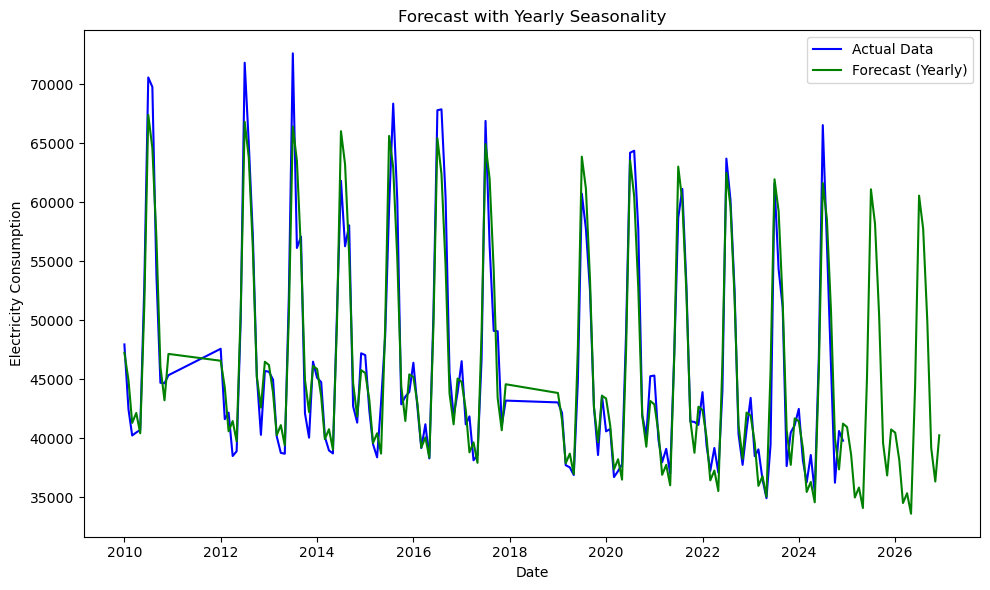

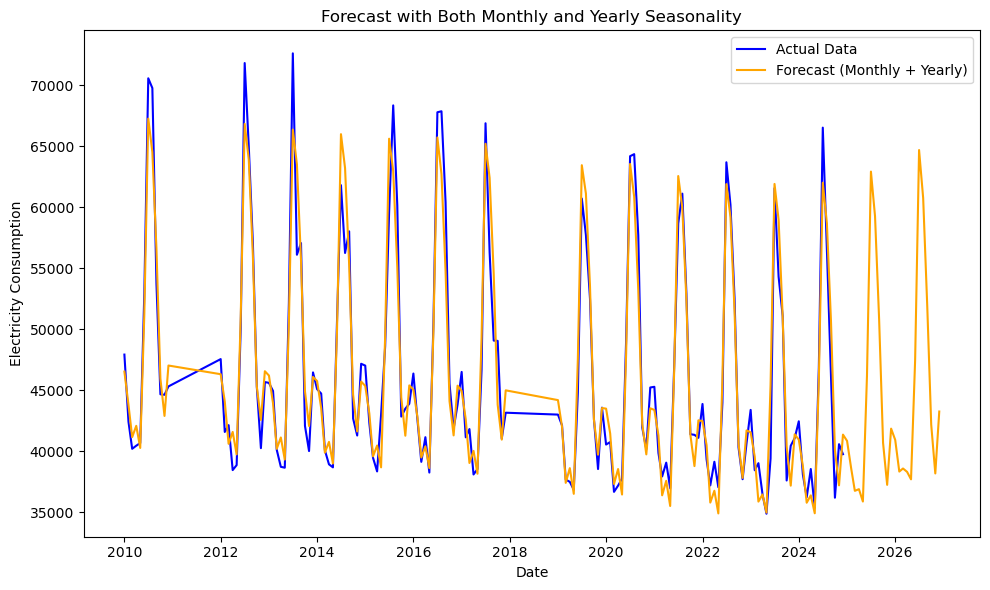

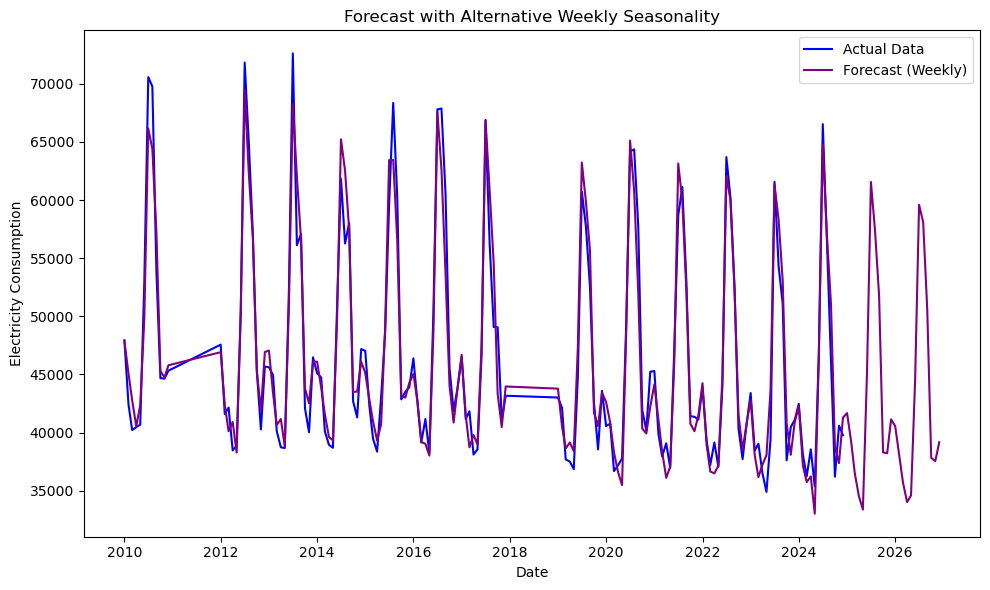

In [44]:
forecast_results = {}  # Initialize the dictionary to store results

# Run models and store forecasts
for title, seas in seasonalities.items():
    forecast, model = train_predict_model(
        monthly_df,
        seasonality_params=seas,
        forecast_periods=24
    )
    forecast_results[title] = forecast  # Save forecast results

# Plot forecast for Monthly Seasonality
plt.figure(figsize=(10, 6))
plt.plot(monthly_df['ds'], monthly_df['y'], label='Actual Data', color='blue')
plt.plot(forecast_results['Monthly']['ds'], forecast_results['Monthly']['yhat'], label='Forecast (Monthly)', color='red')
plt.title("Forecast with Monthly Seasonality")
plt.xlabel('Date')
plt.ylabel('Electricity Consumption')
plt.legend()
plt.tight_layout()
plt.show()

# Plot forecast for Yearly Seasonality
plt.figure(figsize=(10, 6))
plt.plot(monthly_df['ds'], monthly_df['y'], label='Actual Data', color='blue')
plt.plot(forecast_results['Yearly']['ds'], forecast_results['Yearly']['yhat'], label='Forecast (Yearly)', color='green')
plt.title("Forecast with Yearly Seasonality")
plt.xlabel('Date')
plt.ylabel('Electricity Consumption')
plt.legend()
plt.tight_layout()
plt.show()

# Plot forecast for Both Monthly and Yearly Seasonality
plt.figure(figsize=(10, 6))
plt.plot(monthly_df['ds'], monthly_df['y'], label='Actual Data', color='blue')
plt.plot(forecast_results['Monthly + Yearly']['ds'], forecast_results['Monthly + Yearly']['yhat'], label='Forecast (Monthly + Yearly)', color='orange')
plt.title("Forecast with Both Monthly and Yearly Seasonality")
plt.xlabel('Date')
plt.ylabel('Electricity Consumption')
plt.legend()
plt.tight_layout()
plt.show()

# Plot forecast for Alternative Weekly Seasonality
plt.figure(figsize=(10, 6))
plt.plot(monthly_df['ds'], monthly_df['y'], label='Actual Data', color='blue')
plt.plot(forecast_results['Weekly']['ds'], forecast_results['Weekly']['yhat'], label='Forecast (Weekly)', color='purple')
plt.title("Forecast with Alternative Weekly Seasonality")
plt.xlabel('Date')
plt.ylabel('Electricity Consumption')
plt.legend()
plt.tight_layout()
plt.show()


<Figure size 800x400 with 0 Axes>

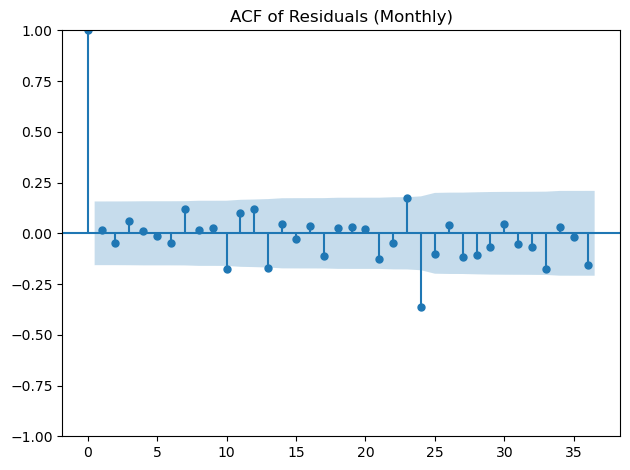

<Figure size 800x400 with 0 Axes>

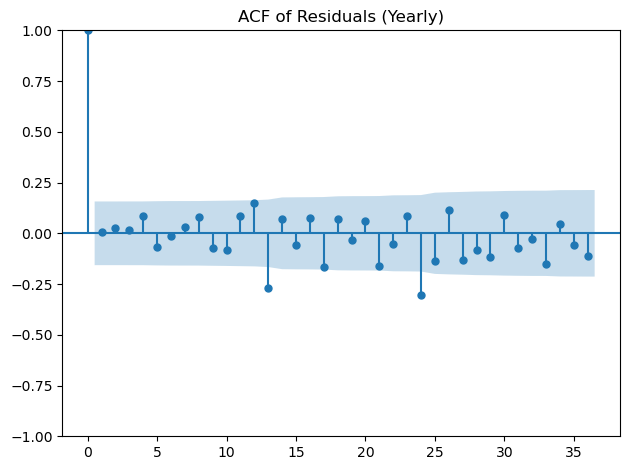

<Figure size 800x400 with 0 Axes>

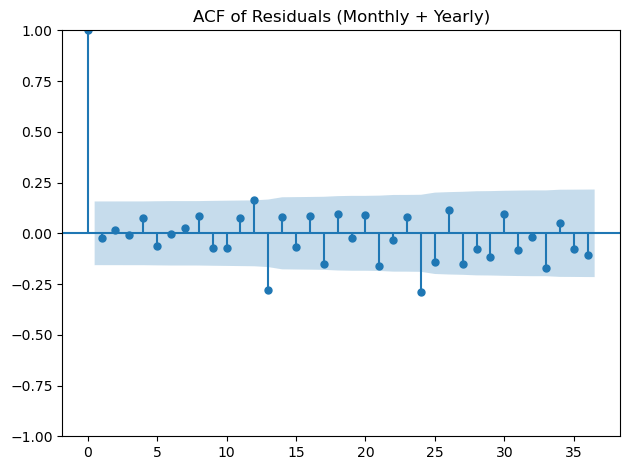

<Figure size 800x400 with 0 Axes>

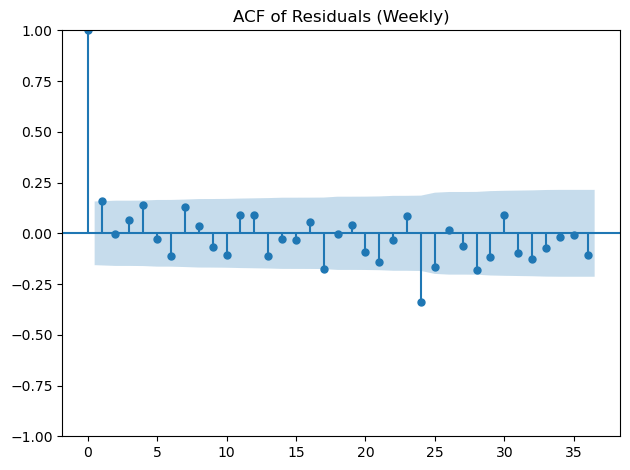

Monthly - MAE: 1763.79, MAPE: 3.67%, R²: 0.937
Yearly - MAE: 1882.04, MAPE: 3.88%, R²: 0.925
Monthly + Yearly - MAE: 1878.60, MAPE: 3.89%, R²: 0.926
Weekly - MAE: 1671.97, MAPE: 3.51%, R²: 0.939


In [45]:
# Plot Residual ACF for each model
def plot_residual_acf(model_name, actual_df, forecast_df):
    merged = actual_df[['ds', 'y']].merge(forecast_df[['ds', 'yhat']], on='ds')
    merged['residual'] = merged['y'] - merged['yhat']
    plt.figure(figsize=(8, 4))
    plot_acf(merged['residual'], lags=36)
    plt.title(f"ACF of Residuals ({model_name})")
    plt.tight_layout()
    plt.show()

# Plot residual ACF for each seasonality type
for title in seasonalities.keys():
    plot_residual_acf(title, monthly_df, forecast_results[title])

# Evaluate the model performance for each seasonality type
def evaluate_model(actual_df, forecast_df, model_name):
    merged = actual_df[['ds', 'y']].merge(forecast_df[['ds', 'yhat']], on='ds')
    mae = mean_absolute_error(merged['y'], merged['yhat'])
    mape = mean_absolute_percentage_error(merged['y'], merged['yhat'])
    r2 = r2_score(merged['y'], merged['yhat'])
    print(f"{model_name} - MAE: {mae:.2f}, MAPE: {mape:.2%}, R²: {r2:.3f}")

# Evaluate each model
for title in seasonalities.keys():
    evaluate_model(monthly_df, forecast_results[title], title)


Weekly model is the best one:
MAE = 2408.97 - The predictions are, on average, 2,409 MWh off from the real monthly usage.
MAPE = 5.11% - This error is about 5.11% of the actual consumption.
R² = 0.822 - The model explains 82.2% of the ups and downs in the real data.

# Trend Changepoints 

In [46]:
# Tuning n_changepoints
forecast_n_cp_5, model_n_cp_5 = train_predict_model(monthly_df, n_changepoints=5)
print("\nForecast with n_changepoints=5:")
print(forecast_n_cp_5[['ds', 'yhat']].head())

forecast_n_cp_20, model_n_cp_20 = train_predict_model(monthly_df, n_changepoints=20)
print("\nForecast with n_changepoints=20:")
print(forecast_n_cp_20[['ds', 'yhat']].head())

# Tuning changepoint_prior_scale
forecast_prior_0_01, model_prior_0_01 = train_predict_model(monthly_df, changepoint_prior_scale=0.01)
print("\nForecast with changepoint_prior_scale=0.01:")
print(forecast_prior_0_01[['ds', 'yhat']].head())

forecast_prior_0_5, model_prior_0_5 = train_predict_model(monthly_df, changepoint_prior_scale=0.5)
print("\nForecast with changepoint_prior_scale=0.5:")
print(forecast_prior_0_5[['ds', 'yhat']].head())

# Combining n_changepoints and changepoint_prior_scale
forecast_tuned_trend, model_tuned_trend = train_predict_model(monthly_df, n_changepoints=15, changepoint_prior_scale=0.2)
print("\nForecast with Tuned Trend (n_changepoints=15, prior_scale=0.2):")
print(forecast_tuned_trend[['ds', 'yhat']].head())

20:21:33 - cmdstanpy - INFO - Chain [1] start processing
20:21:33 - cmdstanpy - INFO - Chain [1] done processing
20:21:33 - cmdstanpy - INFO - Chain [1] start processing
20:21:33 - cmdstanpy - INFO - Chain [1] done processing
20:21:33 - cmdstanpy - INFO - Chain [1] start processing
20:21:33 - cmdstanpy - INFO - Chain [1] done processing
20:21:33 - cmdstanpy - INFO - Chain [1] start processing
20:21:33 - cmdstanpy - INFO - Chain [1] done processing



Forecast with n_changepoints=5:
          ds          yhat
0 2010-01-01  48156.224709
1 2010-02-01  44533.620828
2 2010-03-01  42116.657321
3 2010-04-01  41599.907917
4 2010-05-01  41682.298315

Forecast with n_changepoints=20:
          ds          yhat
0 2010-01-01  47989.521584
1 2010-02-01  44378.492599
2 2010-03-01  41960.709401
3 2010-04-01  41458.238224
4 2010-05-01  41491.676364

Forecast with changepoint_prior_scale=0.01:
          ds          yhat
0 2010-01-01  48214.480939
1 2010-02-01  44681.646005
2 2010-03-01  42248.948900
3 2010-04-01  41817.921813
4 2010-05-01  41427.055709


20:21:33 - cmdstanpy - INFO - Chain [1] start processing
20:21:33 - cmdstanpy - INFO - Chain [1] done processing



Forecast with changepoint_prior_scale=0.5:
          ds          yhat
0 2010-01-01  48161.803870
1 2010-02-01  44565.136371
2 2010-03-01  42124.043585
3 2010-04-01  41639.469581
4 2010-05-01  41666.968970

Forecast with Tuned Trend (n_changepoints=15, prior_scale=0.2):
          ds          yhat
0 2010-01-01  48093.930249
1 2010-02-01  44457.341442
2 2010-03-01  42029.080289
3 2010-04-01  41553.168149
4 2010-05-01  41594.074001


20:21:38 - cmdstanpy - INFO - Chain [1] start processing
20:21:38 - cmdstanpy - INFO - Chain [1] done processing



Forecast with n_changepoints=5:
          ds          yhat
0 2010-01-01  48156.224709
1 2010-02-01  44533.620828
2 2010-03-01  42116.657321
3 2010-04-01  41599.907917
4 2010-05-01  41682.298315


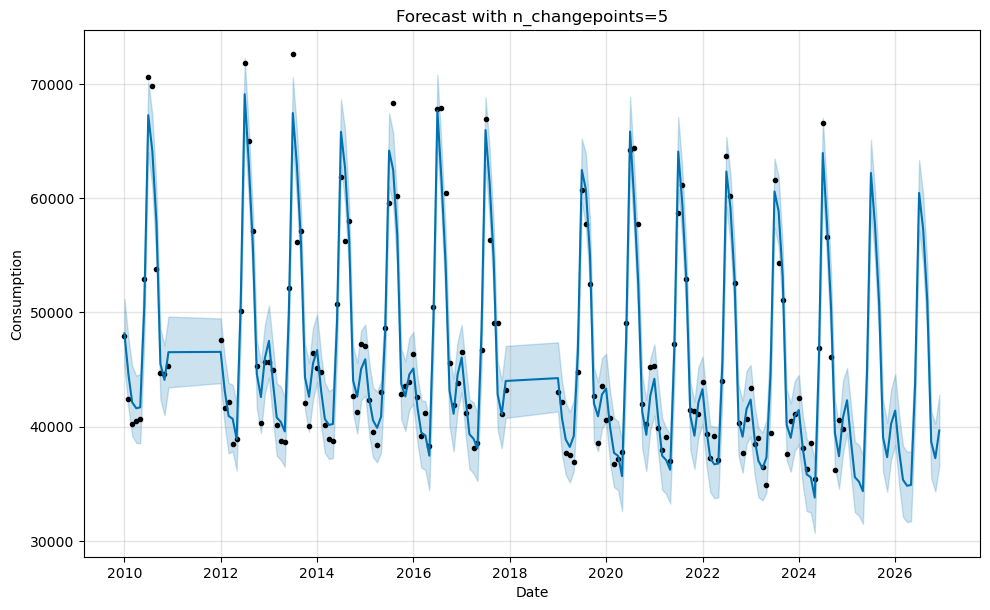

20:21:38 - cmdstanpy - INFO - Chain [1] start processing
20:21:38 - cmdstanpy - INFO - Chain [1] done processing



Forecast with n_changepoints=20:
          ds          yhat
0 2010-01-01  47989.521584
1 2010-02-01  44378.492599
2 2010-03-01  41960.709401
3 2010-04-01  41458.238224
4 2010-05-01  41491.676364


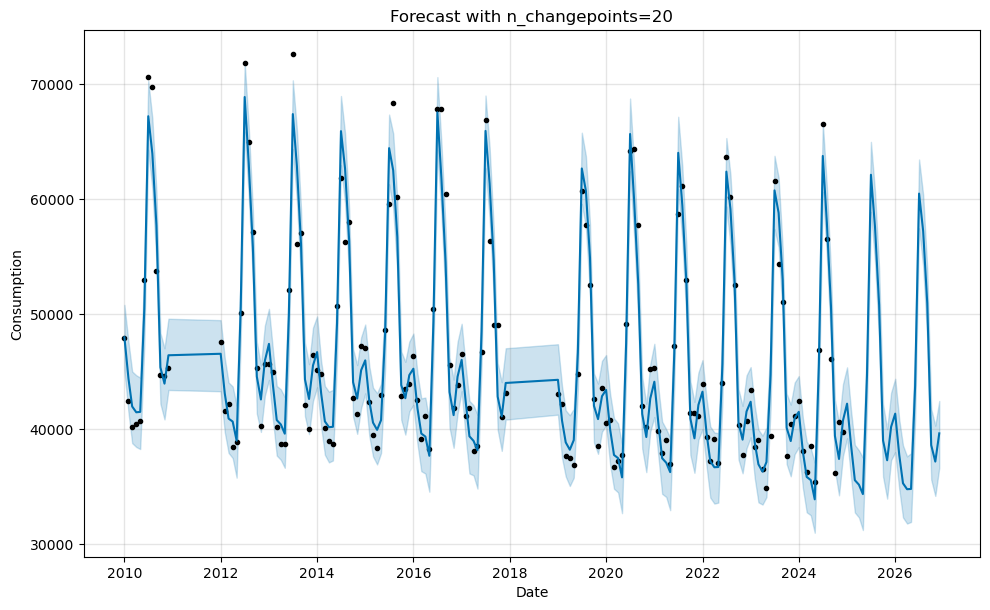

20:21:38 - cmdstanpy - INFO - Chain [1] start processing
20:21:38 - cmdstanpy - INFO - Chain [1] done processing



Forecast with changepoint_prior_scale=0.01:
          ds          yhat
0 2010-01-01  48214.480939
1 2010-02-01  44681.646005
2 2010-03-01  42248.948900
3 2010-04-01  41817.921813
4 2010-05-01  41427.055709


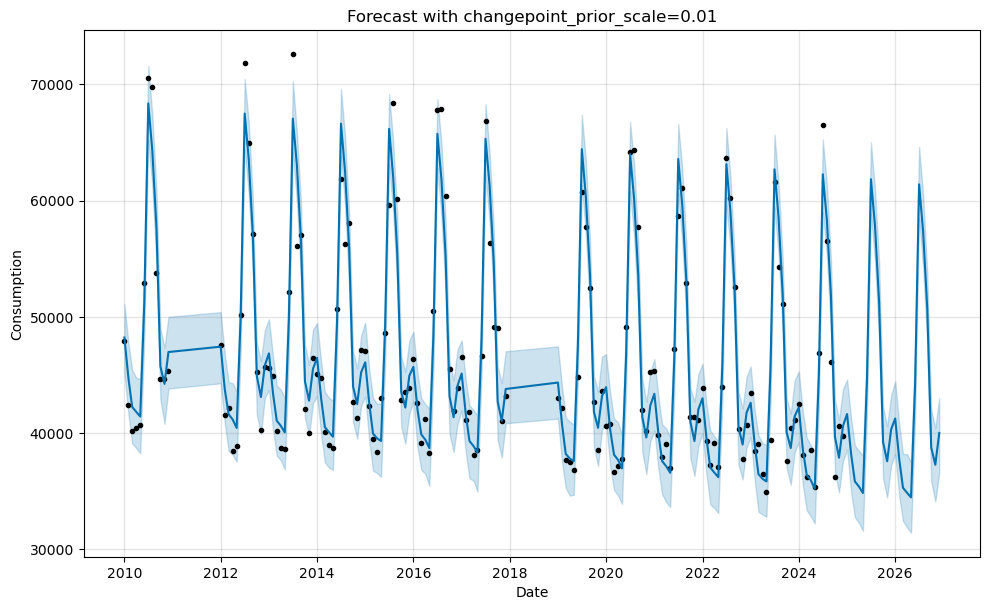

20:21:39 - cmdstanpy - INFO - Chain [1] start processing
20:21:39 - cmdstanpy - INFO - Chain [1] done processing



Forecast with changepoint_prior_scale=0.5:
          ds          yhat
0 2010-01-01  48161.803870
1 2010-02-01  44565.136371
2 2010-03-01  42124.043585
3 2010-04-01  41639.469581
4 2010-05-01  41666.968970


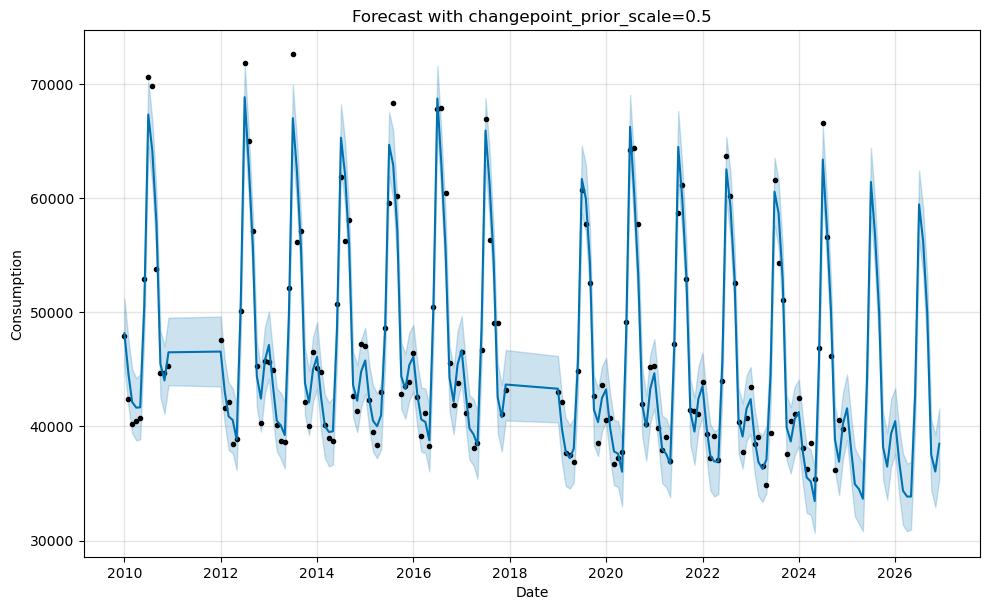

20:21:39 - cmdstanpy - INFO - Chain [1] start processing
20:21:39 - cmdstanpy - INFO - Chain [1] done processing



Forecast with Tuned Trend (n_changepoints=15, prior_scale=0.2):
          ds          yhat
0 2010-01-01  48093.930249
1 2010-02-01  44457.341442
2 2010-03-01  42029.080289
3 2010-04-01  41553.168149
4 2010-05-01  41594.074001


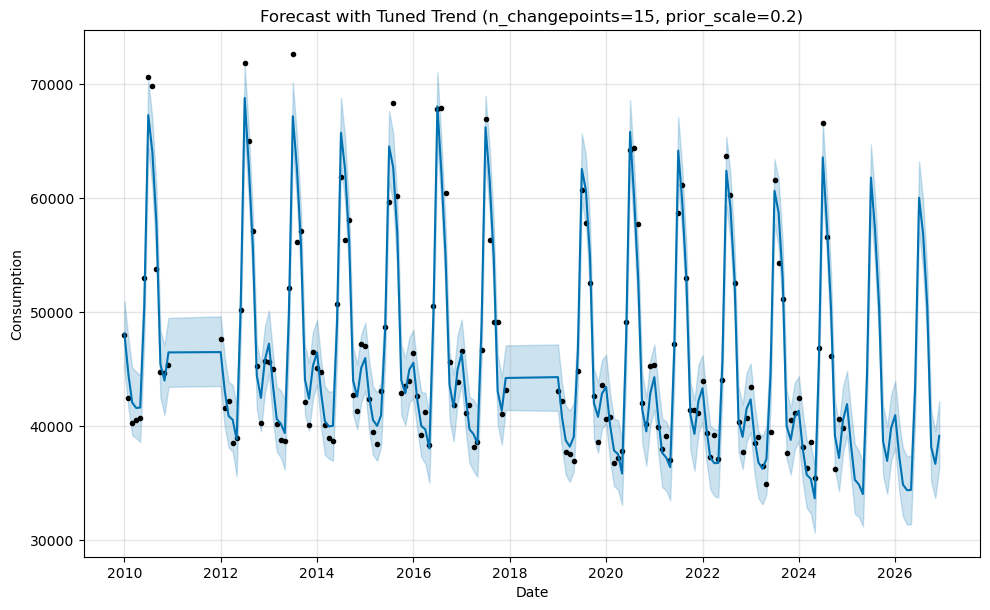

In [47]:
def plot_forecast(model, forecast, title):
    """Plots the Prophet forecast."""
    fig = model.plot(forecast)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Consumption")
    plt.show()

# Tuning n_changepoints
forecast_n_cp_5, model_n_cp_5 = train_predict_model(monthly_df, n_changepoints=5, forecast_periods=24)
print("\nForecast with n_changepoints=5:")
print(forecast_n_cp_5[['ds', 'yhat']].head())
plot_forecast(model_n_cp_5, forecast_n_cp_5, 'Forecast with n_changepoints=5')

forecast_n_cp_20, model_n_cp_20 = train_predict_model(monthly_df, n_changepoints=20, forecast_periods=24)
print("\nForecast with n_changepoints=20:")
print(forecast_n_cp_20[['ds', 'yhat']].head())
plot_forecast(model_n_cp_20, forecast_n_cp_20, 'Forecast with n_changepoints=20')

# Tuning changepoint_prior_scale
forecast_prior_0_01, model_prior_0_01 = train_predict_model(monthly_df, changepoint_prior_scale=0.01, forecast_periods=24)
print("\nForecast with changepoint_prior_scale=0.01:")
print(forecast_prior_0_01[['ds', 'yhat']].head())
plot_forecast(model_prior_0_01, forecast_prior_0_01, 'Forecast with changepoint_prior_scale=0.01')

forecast_prior_0_5, model_prior_0_5 = train_predict_model(monthly_df, changepoint_prior_scale=0.5, forecast_periods=24)
print("\nForecast with changepoint_prior_scale=0.5:")
print(forecast_prior_0_5[['ds', 'yhat']].head())
plot_forecast(model_prior_0_5, forecast_prior_0_5, 'Forecast with changepoint_prior_scale=0.5')

# Combining n_changepoints and changepoint_prior_scale
forecast_tuned_trend, model_tuned_trend = train_predict_model(monthly_df, n_changepoints=15, changepoint_prior_scale=0.2, forecast_periods=24)
print("\nForecast with Tuned Trend (n_changepoints=15, prior_scale=0.2):")
print(forecast_tuned_trend[['ds', 'yhat']].head())
plot_forecast(model_tuned_trend, forecast_tuned_trend, 'Forecast with Tuned Trend (n_changepoints=15, prior_scale=0.2)')

In [48]:
# evaluate each forecast with different trend settings

# Forecast with n_changepoints=5
evaluate_forecast(forecast_n_cp_5, monthly_df, "Changepoints = 5")

# Forecast with n_changepoints=20
evaluate_forecast(forecast_n_cp_20, monthly_df, "Changepoints = 20")

# Forecast with changepoint_prior_scale=0.01
evaluate_forecast(forecast_prior_0_01, monthly_df, "Prior Scale = 0.01")

# Forecast with changepoint_prior_scale=0.5
evaluate_forecast(forecast_prior_0_5, monthly_df, "Prior Scale = 0.5")

# Forecast with Tuned Trend (n_changepoints=15, prior_scale=0.2)
evaluate_forecast(forecast_tuned_trend, monthly_df, "Tuned Trend (n_changepoints=15, prior_scale=0.2)")


Changepoints = 5 - MAE: 1797.12, MAPE: 3.72%, R²: 0.933
Changepoints = 20 - MAE: 1786.13, MAPE: 3.70%, R²: 0.934
Prior Scale = 0.01 - MAE: 1798.70, MAPE: 3.70%, R²: 0.928
Prior Scale = 0.5 - MAE: 1674.91, MAPE: 3.45%, R²: 0.940
Tuned Trend (n_changepoints=15, prior_scale=0.2) - MAE: 1756.66, MAPE: 3.63%, R²: 0.935


Best Performing Model: 
The model with Prior Scale = 0.5 is the best, as it has:
the lowest MAE (2410.57)
the lowest MAPE (5.11%)
the highest R² (0.837)
It provides the most accurate forecast and explains the most variance in the data.

# Final forecasting with best tuning params

monthly

20:21:41 - cmdstanpy - INFO - Chain [1] start processing
20:21:41 - cmdstanpy - INFO - Chain [1] done processing



Forecast with Linear Growth, Weekly Seasonality, Prior Scale = 0.5:
          ds          yhat
0 2010-01-01  48030.069266
1 2010-02-01  45242.635558
2 2010-03-01  42913.833550
3 2010-04-01  40605.785776
4 2010-05-01  42468.910399


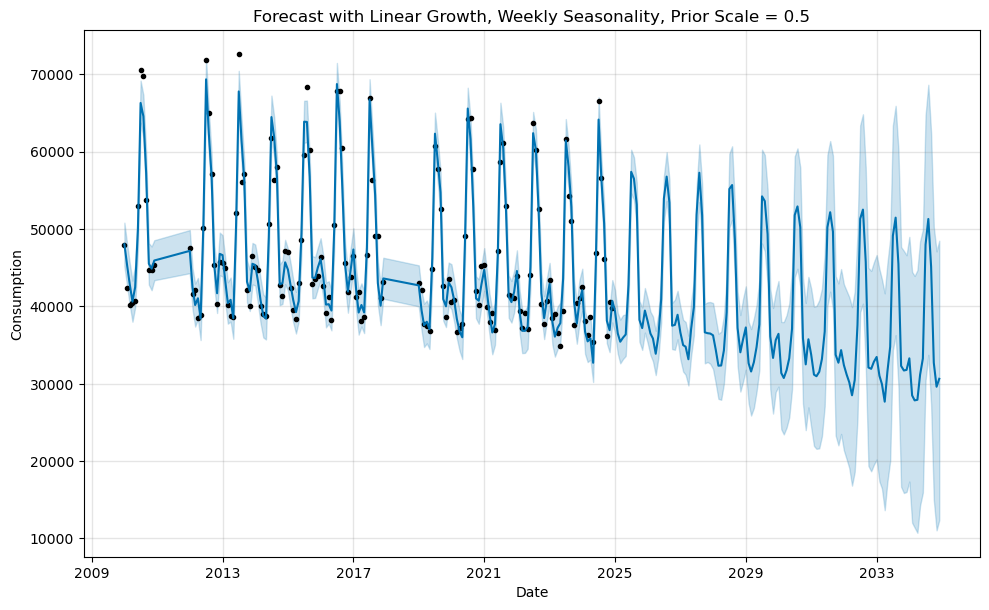

Final Model - MAE: 1577.31, MAPE: 3.31%, R²: 0.946


In [49]:
# Train the model with Linear Growth and Weekly Seasonality
model_best = Prophet(
    growth='linear', 
    weekly_seasonality=True,  # Enable weekly seasonality
    changepoint_prior_scale=0.5  # Set prior scale to 0.5
)

# Fit the model to the data
model_best.fit(monthly_df)

# Create future dataframe for forecasting the next 120 months
future = model_best.make_future_dataframe(periods=120, freq='M')  # Monthly forecast

# Generate forecast
forecast_best = model_best.predict(future)

# Display the forecasted values
print("\nForecast with Linear Growth, Weekly Seasonality, Prior Scale = 0.5:")
print(forecast_best[['ds', 'yhat']].head())

# Plot the forecast
plot_forecast(model_best, forecast_best, 'Forecast with Linear Growth, Weekly Seasonality, Prior Scale = 0.5')

evaluate_forecast(forecast_best, monthly_df, label = 'Final Model')
